# Tutuila Weather Station Gap Filling using same variable from PPG and other stations

Notes: 
    for now using only daily values. Can sub to hourly later maybe if want?



#### Approach:
This script uses deep learning to assess the relationship between like variables recorded at different station loacations to fill in gaps in datasets. Because the algorithim needs as much comparative data as possible, an unbroken record from at least one station is needed to start the process. The algorithm relies on using a master station, the PPG airport, where there is no missing data to train a network for regression of each variable at each other station. But of course, the airport station has it's own data gaps. These are currently filled by using data from other variables in a DL network. This approach is prelimiary and should be ammended when can...


#### Methods: 
    
1: Fill in gaps in PPG Airport Data using other variables as the training data. 



### Use this cell only if working on colaboratory: use this to pull the project off of github

In [ ]:
#### havent started yet!

In [1]:
# Clone the entire repo.   (just for using google colab)
!git clone -l -s git://github.com/cshuler/Machine_Learning_Magic_gap_filling
%cd Machine_Learning_Magic_gap_filling/Scripts
!ls

[WinError 3] The system cannot find the path specified: 'Machine_Learning_Magic_gap_filling/Scripts'
E:\AmericanSamoa\Projects\ASPA_Github_projects\Machine_Learning_Magic_gap_filling\Scripts


'git' is not recognized as an internal or external command,
operable program or batch file.
'ls' is not recognized as an internal or external command,
operable program or batch file.


### Import libararies, set paths and options
note if in colab must use %matplotlib inline

In [3]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container { width: 95%;} div#menubar-container { width: 85%; } div#maintoolbar-container { width: 99%; } </style> """))

# %matplotlib inline
%matplotlib notebook

import matplotlib 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import seaborn as sns
import os
import io
import datetime
from dateutil import parser, rrule
from datetime import datetime, time, date
import time
import keras 
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import requests
import scipy
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import re


workspace = os.path.join('.', 'workspace')
#make sure workspace directory exists
if not os.path.exists(workspace):
    os.makedirs(workspace)


pd.set_option('display.max_rows', 50)    
np.set_printoptions(suppress=True)

### Define some functions used throughout the script

In [4]:
# Display training progress by printing a vertical bar for each completed epoch   (bogs down the run speed significantly)
class print_verticalbar(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 800 == 0: print('\n')
        if epoch % 10 == 0: print('|', end='')
    def on_train_end(self, logs):
        print('- Done!!')
    def on_test_end(self, logs):
        pass
    def on_test_begin(self, logs):
        pass       
    def on_test_batch_begin(self, epoch, logs):
        pass
    def on_test_batch_end(self, epoch, logs):
        pass

In [5]:
### This is used to Identify and label places where there are gaps in the data

def find_date_gaps(dataset_raw, Colinterest):

    a = dataset_raw[Colinterest].values  # Extract out relevant column from dataframe as array
    ## Now gap filling time: 
    # First: all of this is to go through each dataset and identify the start and the end of each gap. 

    m = np.concatenate(( [True], np.isnan(a), [True] ))  # Mask
    ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2)   # Start-stop limits

    gapstarts_L = []; gapends_L = []
    # this is if the series started late, i.e. the first gap is at the beginning
    if ss[0][0] != 0:     
        gapstart = 0
        gapstarts_L.append(gapstart)
        for m in ss:
            gapstart2 = m[1]
            gapstarts_L.append(gapstart2)
            gapends_L.append(m[0])
        del gapstarts_L[-1]                       # the end number is not the start of a new gap so delete this 

    # this is if the series starst at the beginning of the data period, first gap is in the middle 
    for m in ss:
        gapstarts_L.append(m[1])
        gapends_L.append(m[0])
    del gapstarts_L[-1]
    del gapends_L[0]

    gapstarts_Dates = []; gapends_Dates = []
    for h in gapstarts_L:
        date5 = dataset_raw.index[h]
        gapstarts_Dates.append(date5)   # this is a list of the starting date of all gaps
    for h in gapends_L:
        date5 = dataset_raw.index[h]
        gapends_Dates.append(date5)     # this is a list of all the ending dates of the gaps
           
    # list the 
    for idx, val in enumerate(gapstarts_Dates):
        length = gapends_Dates[idx] -gapstarts_Dates[idx]
        print("gap {} is {} from {} to {}".format(idx, length, gapstarts_Dates[idx], gapends_Dates[idx] ))
    
    return gapstarts_Dates, gapends_Dates

In [125]:
# this is used to ID gaps and Autofill less than two day long ones

def ID_n_Fill_gaps(dataset_raw):
    
    dataset_cleanish = dataset_raw.copy()    # create output dataset to map fixed data into
    
    for col in dataset_raw.columns: 
        print('...................................................................................')
        print("{} gaps are".format(col))
        
        # ID gaps
        gapstarts_Dates, gapends_Dates =  find_date_gaps(dataset_raw, col)
        
        # Now fill gaps of one day by using average of yesterday's and tomorrow's values
        for idx, val in enumerate(gapstarts_Dates):
            strt = gapstarts_Dates[idx]                                             # note this is the first day with missing data, if only one this is the missing day
            ends = gapends_Dates[idx]                                               # this is the day where there is data again after a gap ( I think) 
            
            if ends - strt < pd.Timedelta('3 day'):                                # if the gap is 1 day long
                beforepoint = dataset_raw[col].loc[strt-pd.Timedelta('3 day')]      # This is the day before the one with the issing data 
                afterpoint = dataset_raw[col].loc[ends]                             # this is the day where there is data again after a gap ( I think) 
                avepoint = np.mean((beforepoint,afterpoint))                        # average of the adjacient values
                dataset_raw[col].loc[strt:ends] = avepoint                       # FILL the GAP with the ave value

        dataset_cleanish[col] = dataset_raw[col]
    
    return dataset_cleanish

In [7]:
# this is the creation of the DLNN model as a function
def define_model_dense(hidden_layer_sizes, input_shape, activation='relu', optimizer='sgd'):
    
    model = "reset"; del model   # redefine, then delete model to make sure previous model weights are DESTROIED!
    model = Sequential()
    
    model.add(Dense(hidden_layer_sizes[0], activation=activation, input_shape=(input_shape, )))
    for hl_size in hidden_layer_sizes[1: ]:
        model.add(Dense(hl_size, activation=activation))
    
    model.add(Dense(1, activation='linear'))
    model.summary()

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])
    
    return model

In [128]:
# This is the function to mke a training dataset. 
""" Variables are: 
    unbroken_data:   is a pandas dataframe of weather variable data, with datetimmes as the index
    x_cols:          is a LIST of the column names for the input variables
    y_col:           is the name (string) of the column of the output variable
    TS_value:     is a decimal value defining how much of the dataset to use for training vs validation (0.99) = 99% training 1% validation
    
(Maybe use NAME: as a string name to assosiate with the output of this function?)
"""

def make_training_dataset(unbroken_data, x_cols, y_col, TS_value = 0.80):
    
    TRAIN_SPLIT = int(len(unbroken_data)*TS_value)     
    # split data for train and validation
    train_data = unbroken_data.iloc[:TRAIN_SPLIT]
    val_data = unbroken_data.iloc[TRAIN_SPLIT:]

    # set up the training datasets
    X_train = train_data[x_cols].values  
    # scale the x component of the training data
    X_train_scaler = StandardScaler().fit(X_train)
    X_train = X_train_scaler.transform(X_train)

    y_train = train_data[y_col].values                 # scale the y data too, and then make the scale unique to use it to unscale the final data later
    y_train = y_train.reshape(-1, 1)
    y_train_scaler = StandardScaler().fit(y_train)
    y_train = y_train_scaler.transform(y_train)


    # set up the validation datasets
    X_val = val_data[x_cols].values  
    # scale the x component of the training data
    X_val_scaler = StandardScaler().fit(X_val)
    X_val = X_val_scaler.transform(X_val)

    y_val = val_data[y_col].values
    y_val = y_val.reshape(-1, 1)
    y_val_scaler = StandardScaler().fit(y_val)
    y_val = y_val_scaler.transform(y_val)

    return X_train, y_train, X_val, y_val, train_data, val_data, y_train_scaler, y_val_scaler, X_train_scaler

In [ ]:
def crop_the_dataset_to_PPG(dataset):

# if the dataset starts before the PPG dataset starts then make it start at PPG start date
    if dataset.index[0] < PPG_Filled.index[0]:
        dataset_startcrop = PPG_Filled.index[0]
    else:
        dataset_startcrop = dataset.index[0]
        
# if the dataset ends after the PPG dataset ends then make it start at PPG start date      
    if dataset.index[-1] > PPG_Filled.index[0]:
        dataset_endcrop = PPG_Filled.index[-1]
    else:
        dataset_endcrop = dataset.index[-1]
        
    return dataset.loc[dataset_startcrop:dataset_endcrop]

# Step 1: Load in datasets from weather stations

### A: Read the gap filled PPG weather file

<IPython.core.display.Javascript object>


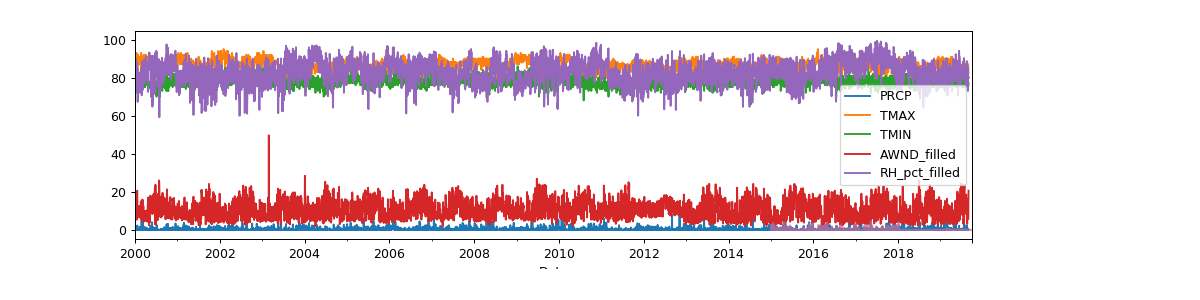

In [43]:
PPG_Filled = pd.read_csv(os.path.join(workspace, "Magic_gap_filled_PPG_data.csv"), index_col=0, parse_dates=True)
PPG_Filled = PPG_Filled.dropna()       # for some reason there is some unfilled data on the end. drop this
PPG_Filled.plot(figsize =(12,3))

### B: Pull UH-ASPA weather data off of my GitHub site
note, reflects most recent update of processed data, not raw data

In [14]:
url = "https://raw.githubusercontent.com/cshuler/ASPA-UH_Integrated_Modeling_Framework/master/ASPA-UH_Wx_REPO/workspace/QA_All_merged.csv"
save_to = os.path.join("..", 'Data', "All_consolodated_Q_m3ps.csv")

r = requests.get(url, allow_redirects=True)
open(save_to, 'wb').write(r.content)

16346953

#### get the data into memory

<IPython.core.display.Javascript object>


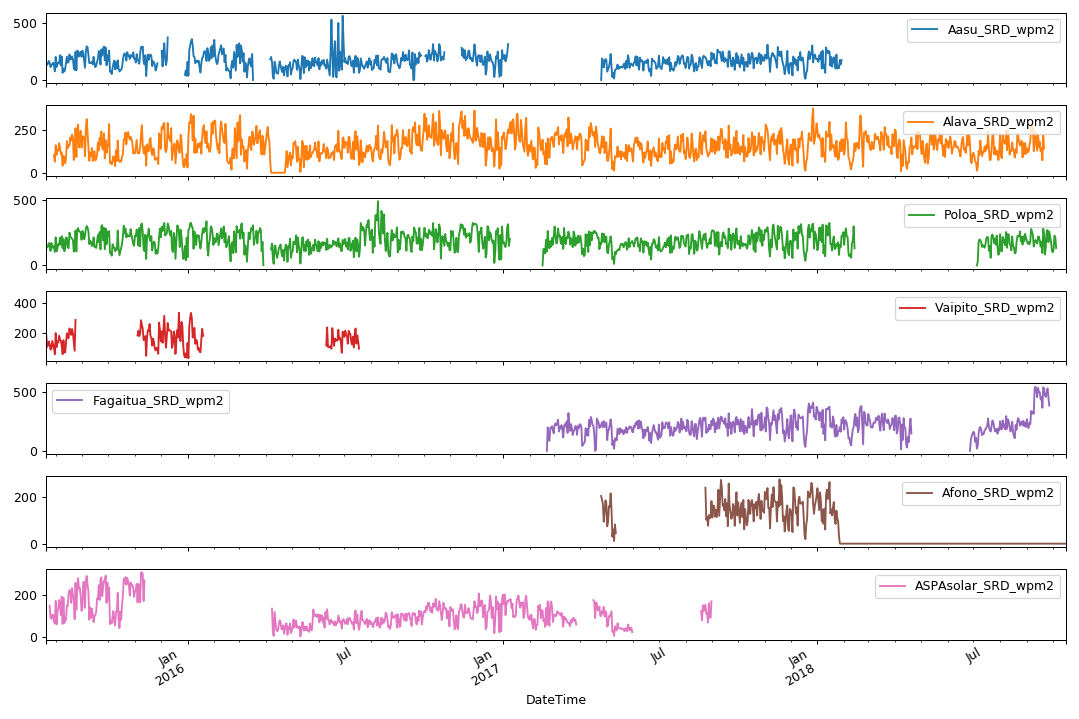

<IPython.core.display.Javascript object>


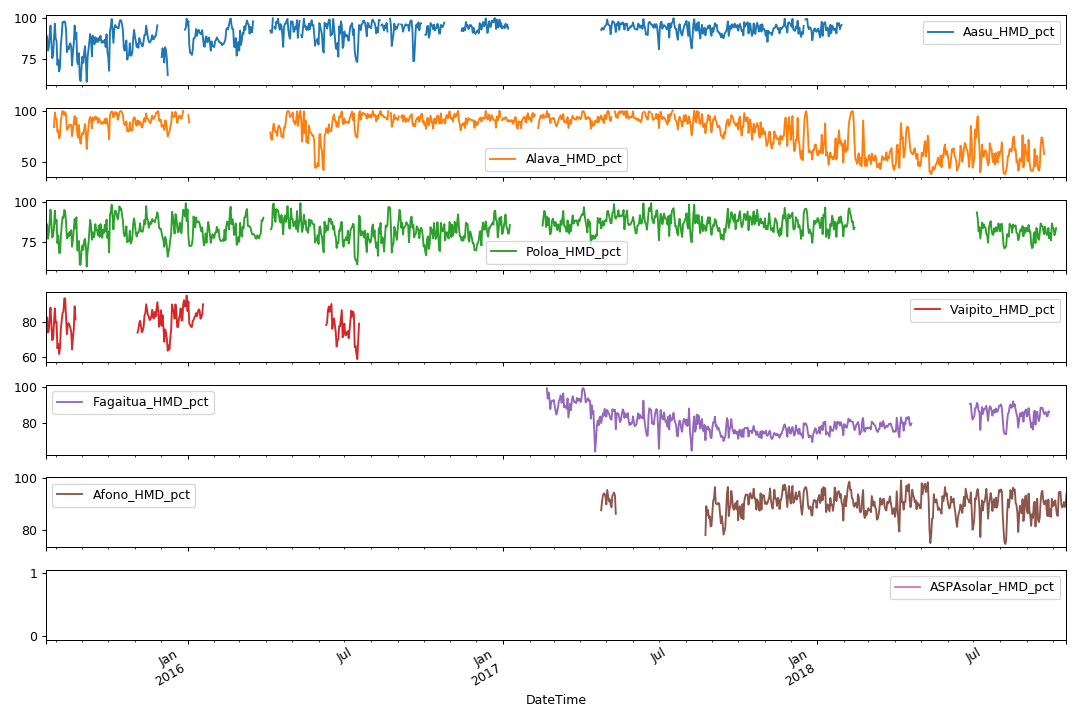

<IPython.core.display.Javascript object>


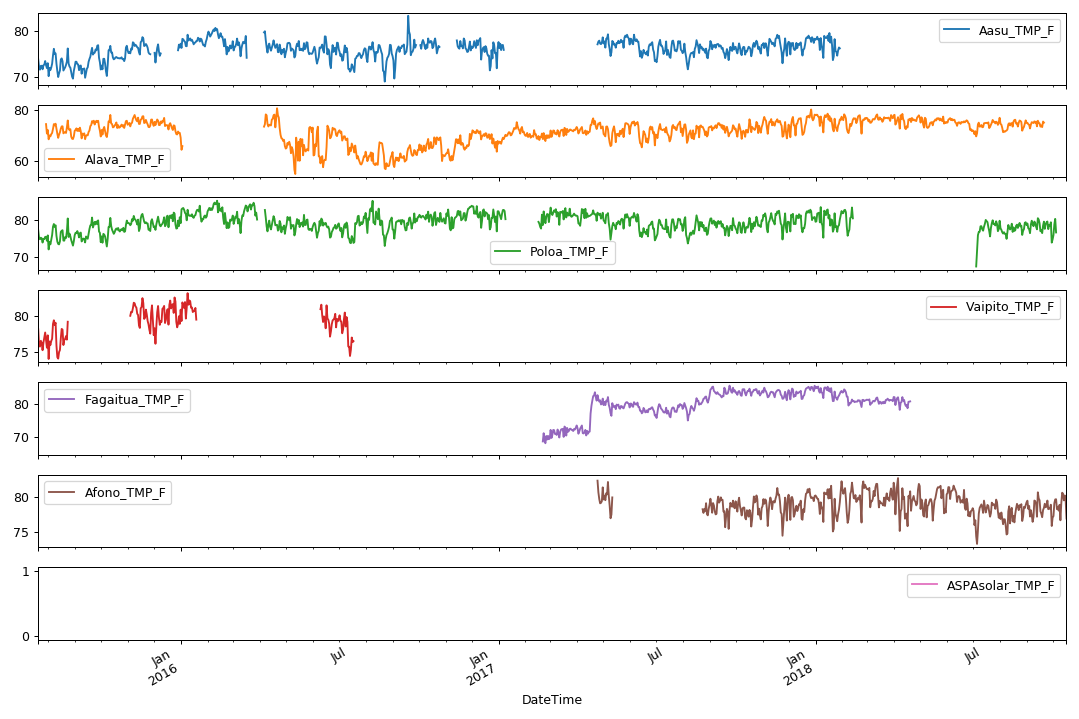

<IPython.core.display.Javascript object>


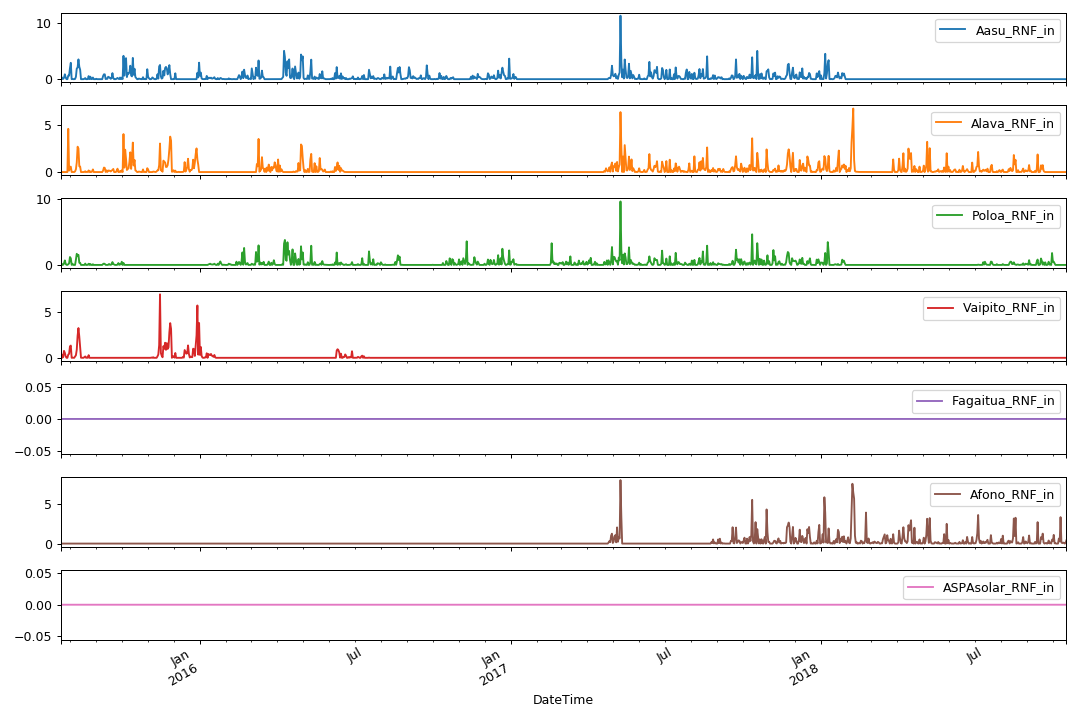

<IPython.core.display.Javascript object>


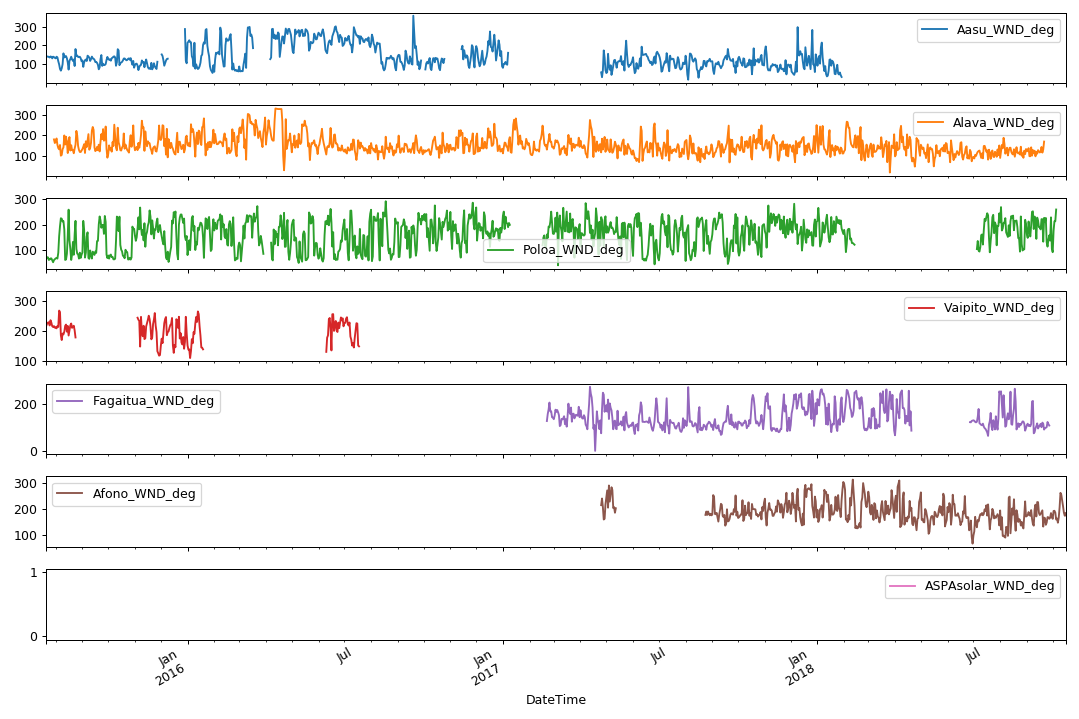

<IPython.core.display.Javascript object>


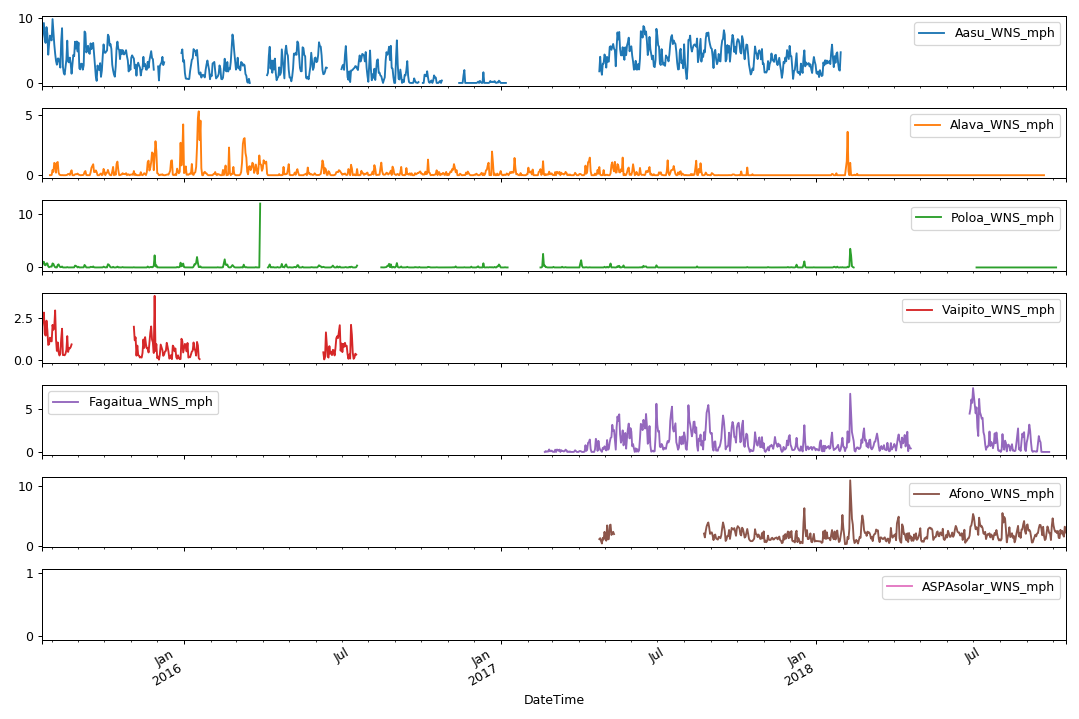

In [15]:
rawdata = pd.read_csv(save_to ,index_col=1,parse_dates=True)   # read in data
rawdata = rawdata.drop(rawdata.columns[0], axis=1)             # get rid of pesky index column

param_list =  ['SRD_wpm2', 'HMD_pct', 'TMP_F', 'RNF_in', 'WND_deg', 'WNS_mph']

ASPA_param_dic = {}
for q in param_list: 
    r = re.compile(".*{}".format(q))  
    Col_list = list(filter(r.match, list(rawdata.columns)))
    tempframe = rawdata[Col_list]
    ASPA_param_dic[q] = tempframe
    
# resample the rainfall to hourly values using a sum method
ASPA_param_dic['RNF_in'] = ASPA_param_dic['RNF_in'].resample('D').sum()     # subsample the 15 min data into daily values
# resample all others to hourly values using a average method
ave_param_list = ['SRD_wpm2', 'HMD_pct', 'TMP_F', 'WND_deg', 'WNS_mph'] 
for i in ave_param_list:
    ASPA_param_dic[i] = ASPA_param_dic[i].resample('D').mean()     # subsample the 15 min data into daily values

# Exoloratory Plot  All the datasets 
for i in param_list: 
    ASPA_param_dic[i].plot(subplots=True, figsize=(12, 8))
    plt.tight_layout()
    plt.legend(loc='best')  

# Tula Data
From Tula weather station, pre-downloaded and living in a file folder, Tula site is: https://www.esrl.noaa.gov/gmd/obop/smo/

### careful, long run time

In [66]:
# processing Tula data into a single dataframe
path_Tula_data = os.path.join("..", "Data", 'External_weather_data', 'Tula', "Met")

trash_cols = ['SITE CODE', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'WND', 'WNS_mpsec', 'WND_STEADY', 'BAR_p', 'TMP_2m', 'TMP_10m', 'TMP_top', 'HMD', 'PRECIP_mm']
want_cols = ['Date', 'PRECIP_mm', 'HMD', 'TMP_2m', 'WND', 'WNS_mpsec']

files = os.listdir(path_Tula_data)                     # get all file names in the folder
na_values = ['-99', '-9', '-999', '-99.9', '-999.9']   #values to turn into NaN 
temp_data =  pd.DataFrame(columns=trash_cols)          # empty container for concat

for i in files: 
    q = pd.read_csv(os.path.join(path_Tula_data, i), delim_whitespace=True, names=trash_cols, na_values=na_values) # open each file
    temp_data = pd.concat([temp_data, q], axis=0)     # stick em all together

temp_data['Date'] = temp_data[['YEAR', 'MONTH', 'DAY', 'HOUR']].apply(lambda x : datetime(*x),axis = 1)  # make the date a date
tula_data2 = temp_data[want_cols].set_index("Date") 

tula_data2['HMD'] = tula_data2['HMD'].apply(lambda x: 100 if x >99.9  else x) #Wtf?  Why are rel HMD values greater than 100%? fix this with some comon sense

# Now resampling data into neeed formats   this is set up for daily resampling 
tula_data2['Tmp_max'] = tula_data2['TMP_2m']                   # just make the columns get ready for resampling
tula_data2['Tmp_min'] = tula_data2['TMP_2m']                  # just make the columns get ready for resampling
tula_data2 = tula_data2.rename(columns={'TMP_2m': 'TMP_ave'})  # just make the columns get ready for resampling

tula_data_rn = tula_data2['PRECIP_mm'].resample('D').sum()      # resample the rain different than the other columns
tula_data_tmax = tula_data2['Tmp_max'].resample('D').max()      # resample the tmax different than the other columns
tula_data_tmin = tula_data2['Tmp_min'].resample('D').min()      # resample the tmin different than the other columns
tula_data_others = tula_data2[['HMD', 'TMP_ave', 'WND', 'WNS_mpsec']].resample('D').mean()   
Tula_data = tula_data_others.join(tula_data_rn)                 #merge tehm back together
Tula_data = Tula_data.join(tula_data_tmin)                 #merge tehm back together
Tula_data = Tula_data.join(tula_data_tmax)                 #merge tehm back together

# unit conversions
Tula_data['RNF_in'] =  Tula_data['PRECIP_mm'].apply(lambda x: x*0.0393701)     # convert rain in mm to rain in inches
Tula_data['TMP_ave_F'] =  Tula_data['TMP_ave'].apply(lambda x: x*1.8 + 32)     # convert rain in mm to rain in inches
Tula_data['TMP_max_F'] =  Tula_data['Tmp_max'].apply(lambda x: x*1.8 + 32)     # convert rain in mm to rain in inches
Tula_data['Tmp_min_F'] =  Tula_data['Tmp_min'].apply(lambda x: x*1.8 + 32)     # convert rain in mm to rain in inches
Tula_data['WNS_mph'] =  Tula_data['WNS_mpsec'].apply(lambda x: x*2.23694)     # convert rain in mm to rain in inches
del Tula_data['WNS_mpsec']; del Tula_data['TMP_ave']; del Tula_data['PRECIP_mm']; del Tula_data['Tmp_max']; del Tula_data['Tmp_min']

# this block is to deal with the separate solar radiation (SLR )files
Path_go_SLR = os.path.join("..", "Data", 'External_weather_data', 'Tula', 'Slr') 

trash_cols = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN', 'DIRECT', 'DIFFUSE2', 'D_GLOBAL', 'D_IR', 'Zenith']
want_cols = ["Date", "DIRECT"]

SLR_files = os.listdir(Path_go_SLR)                     # get all file names in the folder
na_values = ['-99', '-9', '-999', '-99.9', '-999.9']   #values to turn into NaN 

temp_data =  pd.DataFrame(columns=trash_cols)          # empty container for concat
for i in SLR_files: 
    q = pd.read_csv(os.path.join(Path_go_SLR, i), delim_whitespace=True, skiprows= range(0,4), names=trash_cols,  na_values=na_values) # open each file     
    temp_data = pd.concat([temp_data, q], axis=0)     # stick em all together

temp_data['Date'] = temp_data[['YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN']].apply(lambda x : datetime(*x),axis = 1)  # make the date a date
tula_SLR2 = temp_data[want_cols].set_index("Date") 
tula_data_SLR = tula_SLR2['DIRECT'].resample('D').mean()      # resample the rain different than the other columns

Tula_data = Tula_data.join(tula_data_SLR)        
Tula_data = Tula_data.rename(columns={'DIRECT': 'SLR_wpm2'})

# this block deals with the fup that the station was obviously down but recording 0s for some periods. 
en10 = int(len(Tula_data)/10)                      # make the acceptable window of days without rain at 10 days.
s = 0; e = 9
for i in range(0,en10):
    if Tula_data['RNF_in'].iloc[s:e].sum() == 0:   # if the drought is more than 10 days long the sensor was bad so change values to nan
        Tula_data['RNF_in'].iloc[s:e] = np.nan
    s+=10; e+=10

# clear up these columns temporarily while I dont care abot these columns 
del Tula_data['WND']
del Tula_data['SLR_wpm2']
del Tula_data['TMP_ave_F']


# manually rmove data where we know it is trash
Tula_data['RNF_in'].loc['2018-01-12':'2019-08-31'] = np.nan

# remove data where it does not overlap with PAgo data 
Tula_data = crop_the_dataset_to_PPG(Tula_data)

<IPython.core.display.Javascript object>


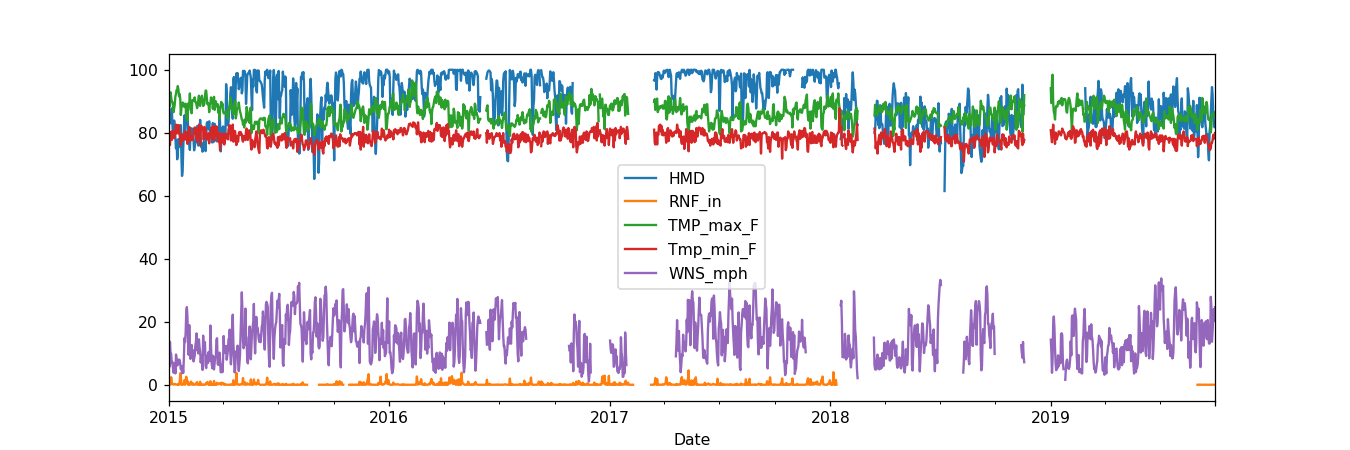

In [184]:
Tula_data.plot(figsize = (12, 4))

# Processing historical ASCC data obtained from Mark

In [18]:
path_ASCC_data_old =  os.path.join("..", "Data", 'External_weather_data', 'ASCC', 'GroWeatherData 2004-2014.csv')
ASCC_All = pd.read_csv(os.path.join(path_ASCC_data_old), parse_dates=[['Date', 'Time']],  keep_date_col=True,  usecols = [0,1, 2, 8, 12, 14, 17, 19], na_values = ["--", "---"])

# clean data
ASCC_All['Date_Time'] = pd.to_datetime(ASCC_All['Date_Time'], errors='coerce')
del ASCC_All['Date']
del ASCC_All['Time']
numcols = ['Air Temp', 'Solar Rad', 'Wind Speed', 'Rain', 'Hum']
for i in numcols:
    ASCC_All[i] = pd.to_numeric(ASCC_All[i], errors='coerce')
ASCC_All = ASCC_All.set_index('Date_Time')

#resample daily 
ASCC_All['Tmp_max'] = ASCC_All['Air Temp']                   # just make the columns get ready for resampling
ASCC_All['Tmp_min'] = ASCC_All['Air Temp']                  # just make the columns get ready for resampling
ASCC_All = ASCC_All.rename(columns={'Air Temp': 'TMP_ave'})  # just make the columns get ready for resampling

ASCC_day_rain = ASCC_All['Rain'].resample('D').sum()     # sum the rainfall by days
ASCC_day_tmax = ASCC_All['Tmp_max'].resample('D').max()      # resample the tmax different than the other columns
ASCC_day_tmin = ASCC_All['Tmp_min'].resample('D').min()      # resample the tmin different than the other columns
ASCC_day_others = ASCC_All[['TMP_ave', 'Solar Rad', 'Wind Speed', 'Hum']].resample('D').mean()   
ASCC_All = ASCC_day_others.join(ASCC_day_rain)                 #merge tehm back together
ASCC_All = ASCC_All.join(ASCC_day_tmax)                 #merge tehm back together
ASCC_All_daily = ASCC_All.join(ASCC_day_tmin)                 #merge tehm back together


# remove trash
ASCC_All_daily[ASCC_All_daily < 0] = np.nan
ASCC_All_daily = ASCC_All_daily.loc[:"2013-12-31"]     # remove trashy data at the end of the stations life

# Convert units 
ASCC_All_daily['Rain'] = ASCC_All_daily['Rain']*0.0393701   # convert mm to in.
ASCC_All_daily['Wind Speed'] = ASCC_All_daily['Wind Speed']*0.621371    # convert km/hr to mi/hr
ASCC_All_daily['Tmp_min'] = ASCC_All_daily['Tmp_min']*(9/5)+32    # convert km/hr to mi/hr
ASCC_All_daily['Tmp_max'] = ASCC_All_daily['Tmp_max']*(9/5)+32    # convert km/hr to mi/hr
ASCC_All_daily['TMP_ave'] = ASCC_All_daily['TMP_ave']*(9/5)+32    # convert km/hr to mi/hr

# distinguish old stion from new 
ASCC_All_daily_old = ASCC_All_daily


############  New station   ##################
# read in data from the new weather station.
path_ASCC_data_new =  os.path.join("..", "Data", 'External_weather_data', 'ASCC', 'ASCCWeatherData_2015-2018_direct.csv')
ASCC_All = pd.read_csv(os.path.join(path_ASCC_data_new), parse_dates=[['Date', 'Time']],  keep_date_col=True,  usecols = [0,1, 2, 5, 7, 8, 17, 19], na_values = ["--", "---"])

# clean data
ASCC_All['Date_Time'] = pd.to_datetime(ASCC_All['Date_Time'], errors='coerce')
del ASCC_All['Date']
del ASCC_All['Time']
ASCC_All = ASCC_All.rename(columns={'OutTemp':'Air Temp', 'HumOut':'Hum', 'SpeedWind':'Wind Speed', 'Rad.Solar':'Solar Rad'})
for i in numcols:
    ASCC_All[i] = pd.to_numeric(ASCC_All[i], errors='coerce')
ASCC_All = ASCC_All.set_index('Date_Time')

#resample daily 

ASCC_All['Tmp_max'] = ASCC_All['Air Temp']                   # just make the columns get ready for resampling
ASCC_All['Tmp_min'] = ASCC_All['Air Temp']                  # just make the columns get ready for resampling
ASCC_All = ASCC_All.rename(columns={'Air Temp': 'TMP_ave'})  # just make the columns get ready for resampling


ASCC_day_rain = ASCC_All['Rain'].resample('D').sum()     # sum the rainfall by days
ASCC_day_tmax = ASCC_All['Tmp_max'].resample('D').max()      # resample the tmax different than the other columns
ASCC_day_tmin = ASCC_All['Tmp_min'].resample('D').min()      # resample the tmin different than the other columns
ASCC_day_others = ASCC_All[['TMP_ave', 'Solar Rad', 'Wind Speed', 'Hum']].resample('D').mean()   
ASCC_All = ASCC_day_others.join(ASCC_day_rain)                 #merge tehm back together
ASCC_All = ASCC_All.join(ASCC_day_tmax)                 #merge tehm back together
ASCC_All_daily = ASCC_All.join(ASCC_day_tmin)                 #merge tehm back together

# Convert units 
ASCC_All_daily['Rain'] = ASCC_All_daily['Rain']*0.0393701   # convert mm to in.
ASCC_All_daily['Wind Speed'] = ASCC_All_daily['Wind Speed']*0.621371    # convert km/hr to mi/hr
ASCC_All_daily['Tmp_min'] = ASCC_All_daily['Tmp_min']*(9/5)+32    # convert km/hr to mi/hr
ASCC_All_daily['Tmp_max'] = ASCC_All_daily['Tmp_max']*(9/5)+32    # convert km/hr to mi/hr
ASCC_All_daily['TMP_ave'] = ASCC_All_daily['TMP_ave']*(9/5)+32    # convert km/hr to mi/hr

# distinguish old stion from new 
ASCC_All_daily_new = ASCC_All_daily

# merge old and new
ASCC_All_combined = pd.concat([ASCC_All_daily_old, ASCC_All_daily_new])

In [19]:
del ASCC_All_combined['TMP_ave']
del ASCC_All_combined['Solar Rad']

<IPython.core.display.Javascript object>


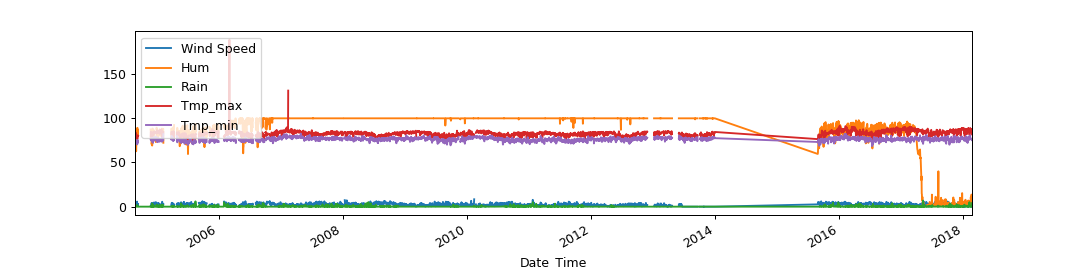

Wind Speed        Hum      Rain  Tmp_max  Tmp_min
Date_Time                                                    
2004-08-26    1.123871  91.739130  0.000000    74.12    73.94
2004-08-27    3.194235  81.326389  0.031496    81.86    73.76
2004-08-28    2.914322  76.980296  0.000000    82.22    74.12
2004-08-29    2.312018  76.781250  0.000000    82.58    73.04
2004-08-30    2.455063  82.052083  0.110236    83.84    73.40
...                ...        ...       ...      ...      ...
2018-02-18    0.020712   7.916667  0.015748    86.90    76.46
2018-02-19    0.020712  13.656250  0.015748    87.26    76.10
2018-02-20    0.000000  12.208333  0.000000    87.44    76.28
2018-02-21    2.447296   2.375000  0.062992    86.72    75.92
2018-02-22    4.213616   1.000000  3.968506    81.86    75.38

[4324 rows x 5 columns]

In [20]:
#fig, ax, = plt.subplots()
ASCC_All_combined.plot(figsize =(12,3))
ASCC_All_combined

# Step 2 Start the big fills 

# 2.1 Tula dataset 
### 2.1.1 ID all gaps and fill any small gaps (2 day or smaller)


In [189]:
dataset_raw = Tula_data.copy() 
dataset_cleanish = ID_n_Fill_gaps(dataset_raw)

...................................................................................
HMD gaps are
gap 0 is 9 days 00:00:00 from 2016-06-01 00:00:00 to 2016-06-10 00:00:00
gap 1 is 1 days 00:00:00 from 2016-09-08 00:00:00 to 2016-09-09 00:00:00
gap 2 is 60 days 00:00:00 from 2016-11-01 00:00:00 to 2016-12-31 00:00:00
gap 3 is 73 days 00:00:00 from 2017-01-01 00:00:00 to 2017-03-15 00:00:00
gap 4 is 2 days 00:00:00 from 2017-10-20 00:00:00 to 2017-10-22 00:00:00
gap 5 is 14 days 00:00:00 from 2017-11-01 00:00:00 to 2017-11-15 00:00:00
gap 6 is 2 days 00:00:00 from 2018-01-16 00:00:00 to 2018-01-18 00:00:00
gap 7 is 1 days 00:00:00 from 2018-01-22 00:00:00 to 2018-01-23 00:00:00
gap 8 is 27 days 00:00:00 from 2018-02-16 00:00:00 to 2018-03-15 00:00:00
gap 9 is 1 days 00:00:00 from 2018-07-04 00:00:00 to 2018-07-05 00:00:00
gap 10 is 3 days 00:00:00 from 2018-07-06 00:00:00 to 2018-07-09 00:00:00
gap 11 is 100 days 00:00:00 from 2018-11-19 00:00:00 to 2019-02-27 00:00:00
...................

In [190]:
# see how the initial filling did and ID other gaps
Check_to_see_where_big_gaps_are = ID_n_Fill_gaps(dataset_cleanish)          # just calling this function on the clean dataset print off a list of the gaps, doesnt do anything since there are no 1 day gaps left. 

...................................................................................
HMD gaps are
gap 0 is 9 days 00:00:00 from 2016-06-01 00:00:00 to 2016-06-10 00:00:00
gap 1 is 60 days 00:00:00 from 2016-11-01 00:00:00 to 2016-12-31 00:00:00
gap 2 is 73 days 00:00:00 from 2017-01-01 00:00:00 to 2017-03-15 00:00:00
gap 3 is 14 days 00:00:00 from 2017-11-01 00:00:00 to 2017-11-15 00:00:00
gap 4 is 27 days 00:00:00 from 2018-02-16 00:00:00 to 2018-03-15 00:00:00
gap 5 is 3 days 00:00:00 from 2018-07-06 00:00:00 to 2018-07-09 00:00:00
gap 6 is 100 days 00:00:00 from 2018-11-19 00:00:00 to 2019-02-27 00:00:00
...................................................................................
RNF_in gaps are
gap 0 is 9 days 00:00:00 from 2015-08-19 00:00:00 to 2015-08-28 00:00:00
gap 1 is 9 days 00:00:00 from 2015-08-29 00:00:00 to 2015-09-07 00:00:00
gap 2 is 9 days 00:00:00 from 2015-10-18 00:00:00 to 2015-10-27 00:00:00
gap 3 is 9 days 00:00:00 from 2017-02-09 00:00:00 to 2017-02-18 00:

### 2.2.2  Filling in longer gaps: Calibration and validation of the network
This shows how well the network matches the training data, this is mainly to assess model performance and uncertainty
note: need to manually definine columns to work with, 

In [191]:
#define the DL model and its parameters to use for other models creates object named model in memory

def make_run_plot_validate_Tula(unbroken_data, x_cols, y_col, hidden_layer_sizes, input_shape, activation, optimizer, TS_value = 0.80 ):

        # format trainng and validation data
        X_train, y_train, X_val, y_val, train_data, val_data, y_train_scaler, y_val_scaler, X_train_scaler = make_training_dataset(unbroken_data, x_cols, y_col, TS_value=0.8)

        model = "reset"; del model                                                           # redefine, then delete model to make sure previous model weights are DESTROIED!
        model = define_model_dense(hidden_layer_sizes, input_shape, activation, optimizer)

        # Note using callbacks from ( https://www.machinecurve.com/index.php/2019/05/30/avoid-wasting-resources-with-earlystopping-and-modelcheckpoint-in-keras/ )
        checkpoint_path = os.path.join(workspace, 'testmodel_random_callback_save2.h5')

        keras_callbacks   = [EarlyStopping(monitor='val_loss', patience=150, mode='min', min_delta=0.001),
                             ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min'), print_verticalbar()]

        history = model.fit(X_train, y_train, epochs=2000,verbose=0, validation_data =(X_val,  y_val), callbacks=keras_callbacks)

        ## load the best saved model based on validation loss
        model = load_model(checkpoint_path)
        scores = model.evaluate(X_train, y_train, verbose=1)
        print(f'Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

        #### Plot results
        fig, ax = plt.subplots(1, 3, figsize=(9, 3))
        ####################################################     DELETE   fig.suptitle('Validation test plots', fontsize=16)

        ######## plot 1 to 1 for # view results of predictions on the calibration data 
        y_pred_calibration = model.predict(X_train)
        y_pred_calibration = y_train_scaler.inverse_transform(y_pred_calibration)    # unscale the final data baed on the scaler from the initial scaling cell abovee

        xcal = np.squeeze(train_data[y_col].values)
        ycal = np.squeeze(y_pred_calibration)
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xcal, ycal)                              # get stats on regression
        mea = np.mean(np.abs(xcal-ycal))
        rmse = np.sqrt(np.mean(np.abs(xcal-ycal)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error
        Std_RMSE = rmse/((np.mean(xcal)+np.mean(ycal))/2)                                 # standardize the RMSE as a % of the mean
        ax[0].plot(np.unique(xcal), np.poly1d(np.polyfit(xcal, ycal, 1))(np.unique(xcal)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
        ax[0].scatter(xcal, ycal, label="r2={0:1.2f}, slope={1:1.2f}\nRMSE={2:1.2f} S_RMSE={3:1.2f}".format(r_value, slope, rmse, Std_RMSE))   
        ax[0].set_title('Actual vs simulated data Calibration')
        ax[0].legend()
        plt.tight_layout()

        ###### Plot losses
        ax[1].set_title('Loss vs. Epoch {}'.format(y_col))
        ax[1].plot(history.history['loss'])
        ax[1].plot(history.history['val_loss'])
        plt.tight_layout()

        ###### plot 1 to 1 for # view results of predictions on the validation data 
        y_pred_validation = model.predict(X_val)
        y_pred_validation = y_val_scaler.inverse_transform(y_pred_validation)    # unscale the final data baed on the scaler from the initial scaling cell abovee
        plt.tight_layout()

        xval = np.squeeze(val_data[y_col].values)
        yval = np.squeeze(y_pred_validation)
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xval, yval)                              # get stats on regression
        mea = np.mean(np.abs(xval-yval))
        rmse = np.sqrt(np.mean(np.abs(xval-yval)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error
        Std_RMSE = rmse/((np.mean(xval)+np.mean(yval))/2)                                 # standardize the RMSE as a % of the mean
        ax[2].plot(np.unique(xval), np.poly1d(np.polyfit(xval, yval, 1))(np.unique(xval)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
        ax[2].scatter(xval, yval, label="r2={0:1.2f}, slope={1:1.2f}\nRMSE={2:1.2f} S_RMSE={3:1.2f}".format(r_value, slope, rmse, Std_RMSE))   
        ax[2].set_title('Actual vs simulated data Validation')
        ax[2].legend()
        plt.tight_layout() 

        ##### time series plot
        plt.figure(figsize=(8, 3))
        plt.plot(train_data.index, ycal, label='Predicted train {}'.format(y_col))
        train_data[y_col].plot(label='Actual train {}'.format(y_col) , alpha = .5)
        plt.plot(val_data.index, yval, label='Predicted validate')
        val_data[y_col].plot(label='Actual validate', alpha = .5)
        plt.legend(loc='best')
        plt.tight_layout()    


working on HMD
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_146 (Dense)            (None, 12)                24        
_________________________________________________________________
dense_147 (Dense)            (None, 80)                1040      
_________________________________________________________________
dense_148 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_149 (Dense)            (None, 1)                 81        
Total params: 7,625
Trainable params: 7,625
Non-trainable params: 0
_________________________________________________________________


|||||||||||||||||||- Done!!
1128/1128 [==============================] - 0s 312us/step
Score: loss of 0.6939595804569569; mean_squared_error of 69.3959653377533%


<IPython.core.display.Javascript object>


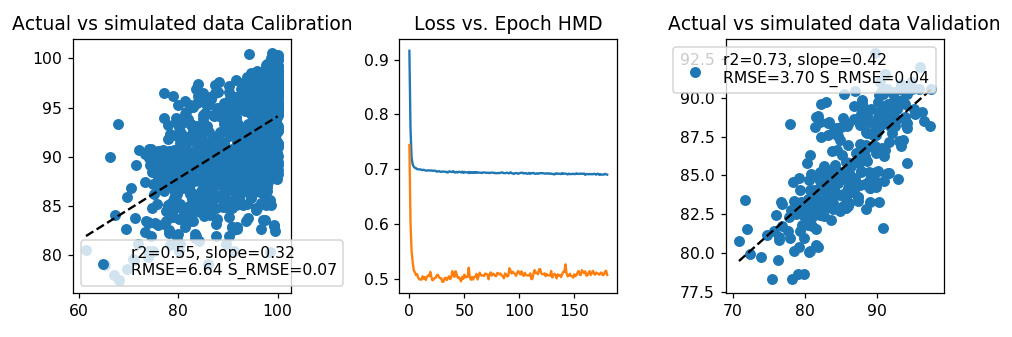

<IPython.core.display.Javascript object>


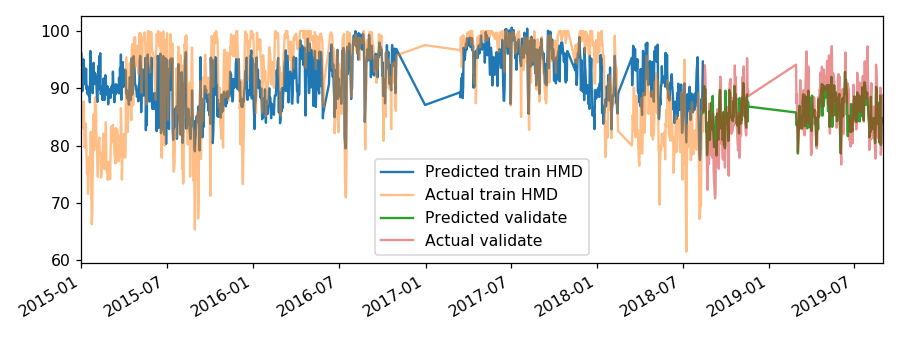

gap 0 is 9 days 00:00:00 from 2016-06-01 00:00:00 to 2016-06-10 00:00:00
gap 1 is 60 days 00:00:00 from 2016-11-01 00:00:00 to 2016-12-31 00:00:00
gap 2 is 73 days 00:00:00 from 2017-01-01 00:00:00 to 2017-03-15 00:00:00
gap 3 is 14 days 00:00:00 from 2017-11-01 00:00:00 to 2017-11-15 00:00:00
gap 4 is 27 days 00:00:00 from 2018-02-16 00:00:00 to 2018-03-15 00:00:00
gap 5 is 3 days 00:00:00 from 2018-07-06 00:00:00 to 2018-07-09 00:00:00
gap 6 is 100 days 00:00:00 from 2018-11-19 00:00:00 to 2019-02-27 00:00:00


<IPython.core.display.Javascript object>


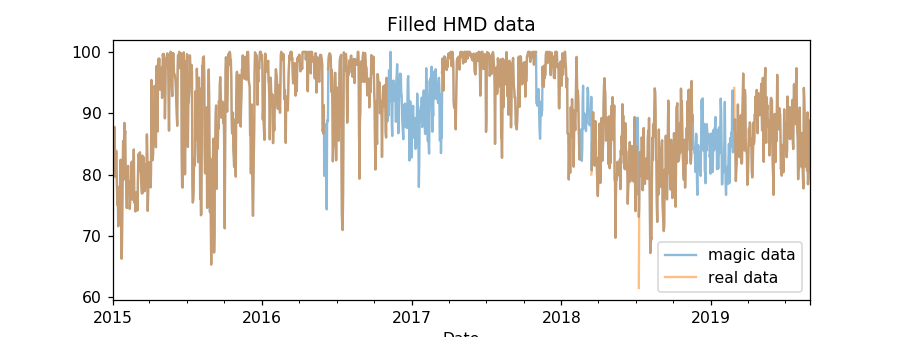

working on Tmp_min_F
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_150 (Dense)            (None, 12)                24        
_________________________________________________________________
dense_151 (Dense)            (None, 80)                1040      
_________________________________________________________________
dense_152 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_153 (Dense)            (None, 1)                 81        
Total params: 7,625
Trainable params: 7,625
Non-trainable params: 0
_________________________________________________________________


||||||||||||||||||||||||||||||||||||||- Done!!
1260/1260 [==============================] - 0s 283us/step
Score: loss of 0.5763742150768402; mean_squared_error of 57.637423276901245%


<IPython.core.display.Javascript object>


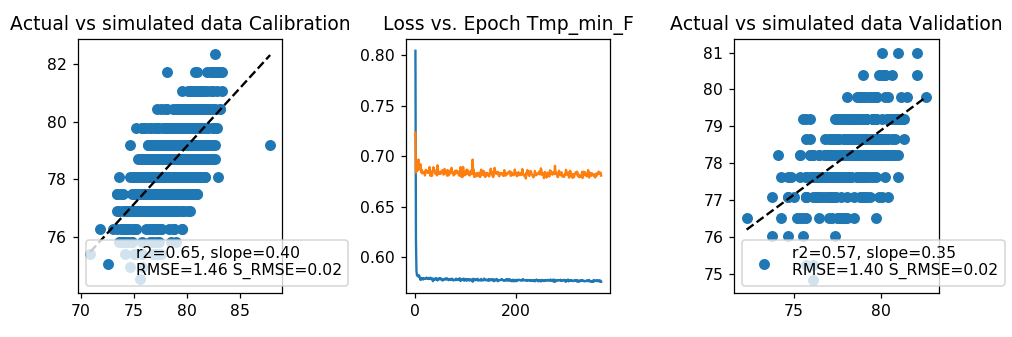

<IPython.core.display.Javascript object>


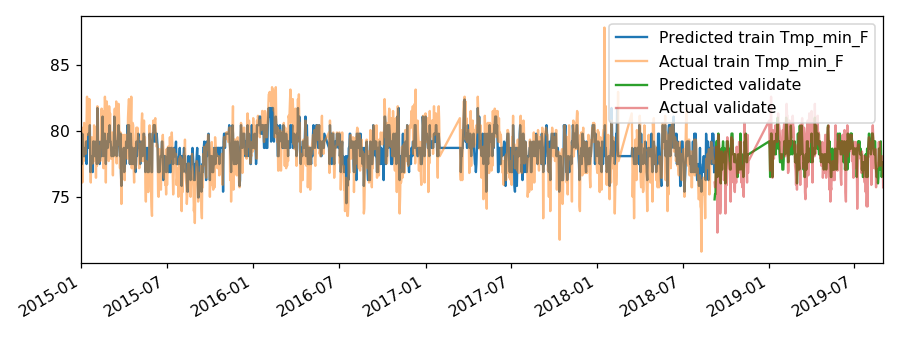

gap 0 is 9 days 00:00:00 from 2016-06-01 00:00:00 to 2016-06-10 00:00:00
gap 1 is 42 days 00:00:00 from 2017-02-01 00:00:00 to 2017-03-15 00:00:00
gap 2 is 27 days 00:00:00 from 2018-02-16 00:00:00 to 2018-03-15 00:00:00
gap 3 is 3 days 00:00:00 from 2018-07-06 00:00:00 to 2018-07-09 00:00:00
gap 4 is 43 days 00:00:00 from 2018-11-19 00:00:00 to 2019-01-01 00:00:00


<IPython.core.display.Javascript object>


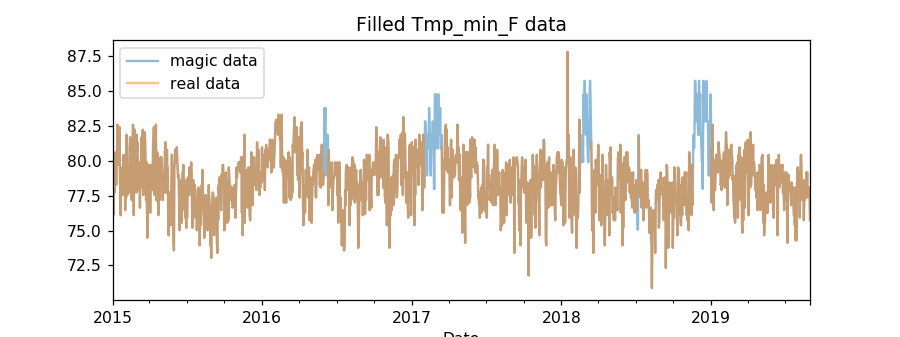

working on TMP_max_F
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_154 (Dense)            (None, 12)                24        
_________________________________________________________________
dense_155 (Dense)            (None, 80)                1040      
_________________________________________________________________
dense_156 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_157 (Dense)            (None, 1)                 81        
Total params: 7,625
Trainable params: 7,625
Non-trainable params: 0
_________________________________________________________________


||||||||||||||||||||||||||||||||||||||||||||||||- Done!!
1260/1260 [==============================] - 0s 318us/step
Score: loss of 0.4649855669528719; mean_squared_error of 46.498554944992065%


<IPython.core.display.Javascript object>


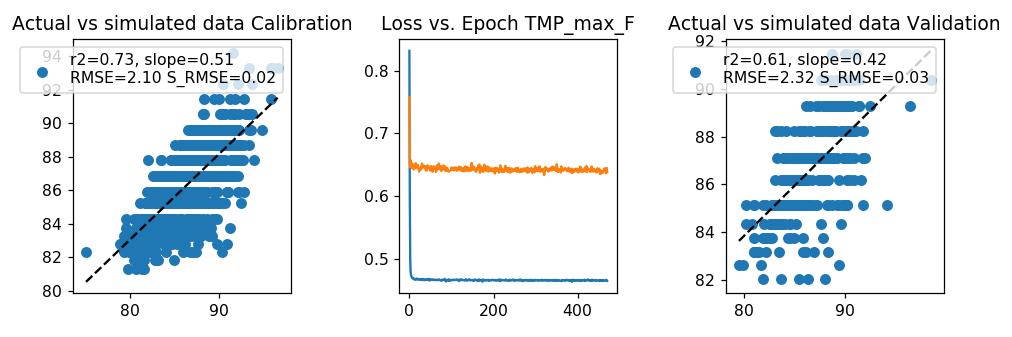

<IPython.core.display.Javascript object>


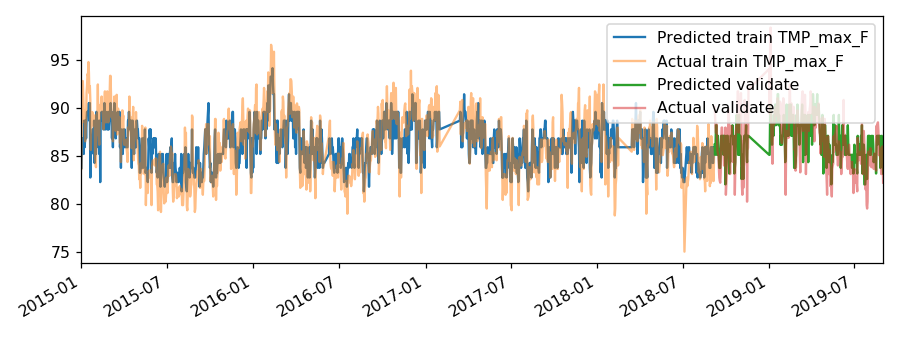

gap 0 is 9 days 00:00:00 from 2016-06-01 00:00:00 to 2016-06-10 00:00:00
gap 1 is 42 days 00:00:00 from 2017-02-01 00:00:00 to 2017-03-15 00:00:00
gap 2 is 27 days 00:00:00 from 2018-02-16 00:00:00 to 2018-03-15 00:00:00
gap 3 is 3 days 00:00:00 from 2018-07-06 00:00:00 to 2018-07-09 00:00:00
gap 4 is 43 days 00:00:00 from 2018-11-19 00:00:00 to 2019-01-01 00:00:00


<IPython.core.display.Javascript object>


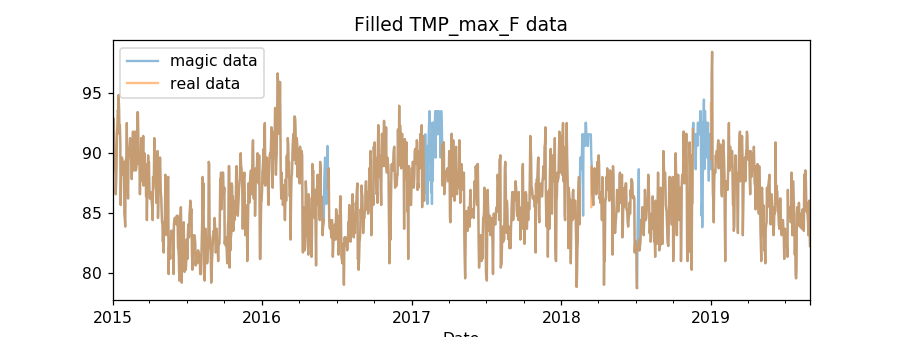

working on RNF_in
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_158 (Dense)            (None, 12)                24        
_________________________________________________________________
dense_159 (Dense)            (None, 80)                1040      
_________________________________________________________________
dense_160 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_161 (Dense)            (None, 1)                 81        
Total params: 7,625
Trainable params: 7,625
Non-trainable params: 0
_________________________________________________________________


||||||||||||||||||||||||||||||||||||||||- Done!!
842/842 [==============================] - 0s 419us/step
Score: loss of 0.7064927129026264; mean_squared_error of 70.64927220344543%


<IPython.core.display.Javascript object>


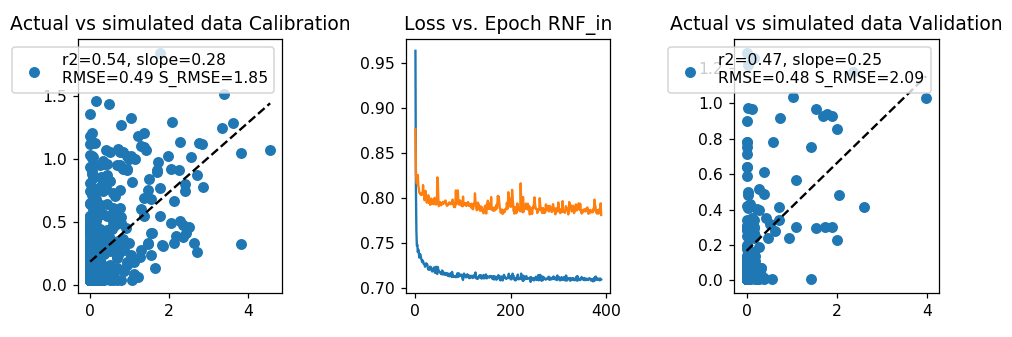

<IPython.core.display.Javascript object>


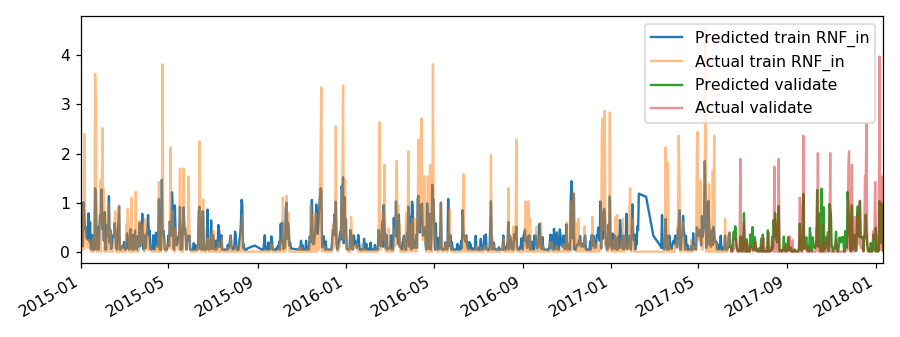

gap 0 is 9 days 00:00:00 from 2015-08-19 00:00:00 to 2015-08-28 00:00:00
gap 1 is 9 days 00:00:00 from 2015-08-29 00:00:00 to 2015-09-07 00:00:00
gap 2 is 9 days 00:00:00 from 2015-10-18 00:00:00 to 2015-10-27 00:00:00
gap 3 is 9 days 00:00:00 from 2017-02-09 00:00:00 to 2017-02-18 00:00:00
gap 4 is 9 days 00:00:00 from 2017-02-19 00:00:00 to 2017-02-28 00:00:00
gap 5 is 9 days 00:00:00 from 2017-03-01 00:00:00 to 2017-03-10 00:00:00


C:\Users\cshuler\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


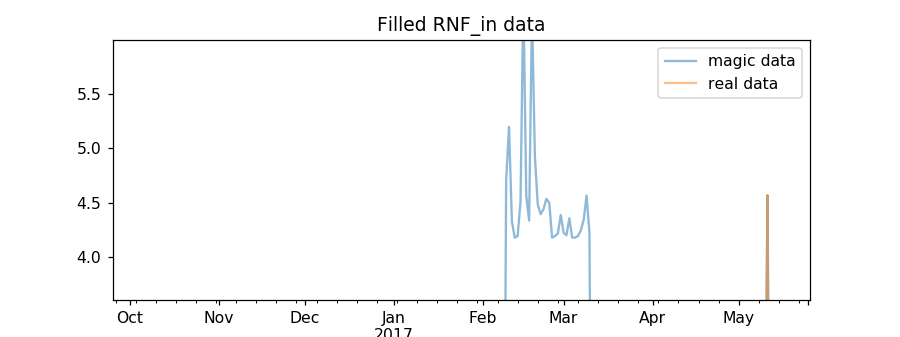

working on WNS_mph
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_162 (Dense)            (None, 12)                24        
_________________________________________________________________
dense_163 (Dense)            (None, 80)                1040      
_________________________________________________________________
dense_164 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_165 (Dense)            (None, 1)                 81        
Total params: 7,625
Trainable params: 7,625
Non-trainable params: 0
_________________________________________________________________


|||||||||||||||||||||||||||||||- Done!!
1044/1044 [==============================] - 0s 366us/step
Score: loss of 0.23146391348820536; mean_squared_error of 23.14639240503311%


C:\Users\cshuler\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


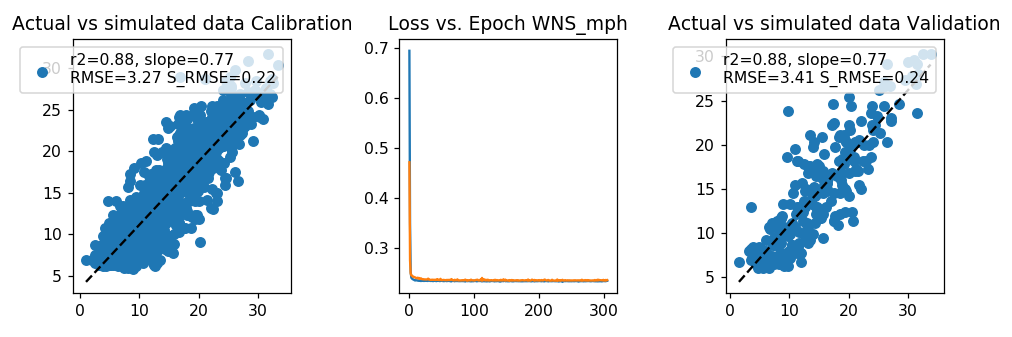

C:\Users\cshuler\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


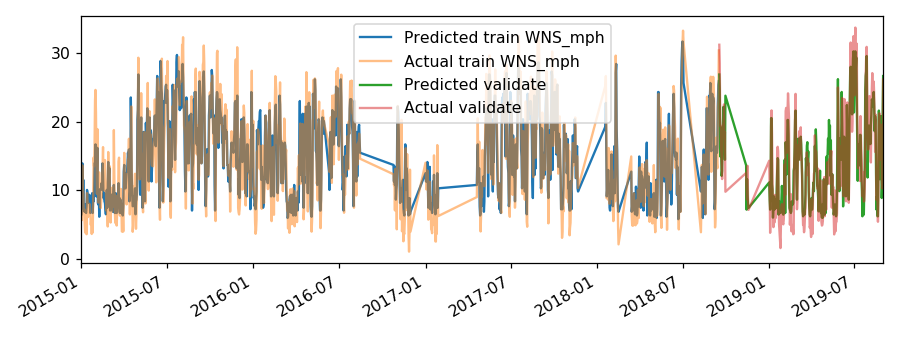

gap 0 is 9 days 00:00:00 from 2016-06-01 00:00:00 to 2016-06-10 00:00:00
gap 1 is 70 days 00:00:00 from 2016-08-16 00:00:00 to 2016-10-25 00:00:00
gap 2 is 31 days 00:00:00 from 2016-12-01 00:00:00 to 2017-01-01 00:00:00
gap 3 is 81 days 00:00:00 from 2017-01-29 00:00:00 to 2017-04-20 00:00:00
gap 4 is 57 days 00:00:00 from 2017-11-22 00:00:00 to 2018-01-18 00:00:00
gap 5 is 26 days 00:00:00 from 2018-02-16 00:00:00 to 2018-03-14 00:00:00
gap 6 is 36 days 00:00:00 from 2018-07-04 00:00:00 to 2018-08-09 00:00:00
gap 7 is 43 days 00:00:00 from 2018-10-01 00:00:00 to 2018-11-13 00:00:00
gap 8 is 43 days 00:00:00 from 2018-11-19 00:00:00 to 2019-01-01 00:00:00


C:\Users\cshuler\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


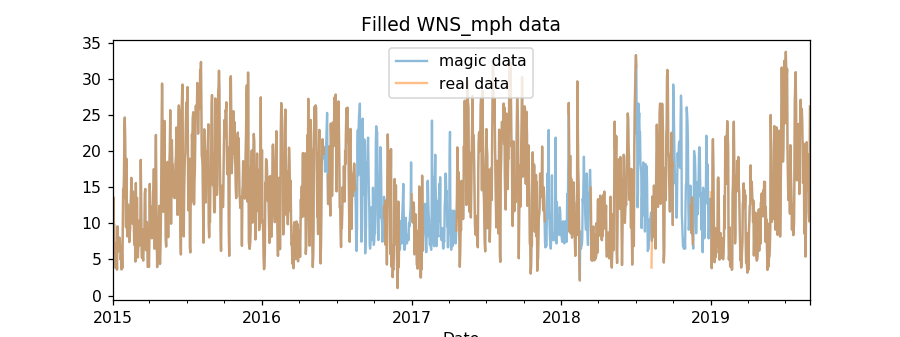

In [192]:
Magic_Tula_data = dataset_cleanish.copy()   # the end result container
list_of_gap_cols = []        # list of columns with gaps

Tula_cols = ['HMD',           'Tmp_min_F', 'TMP_max_F', 'RNF_in',  'WNS_mph']
PPG_cols  = ['RH_pct_filled', 'TMIN',      'TMAX',      'PRCP',    'AWND_filled']

# set up training data with the PPG and Tula variables
for idx, tcol in enumerate(Tula_cols):
    print("working on {}".format(tcol))
    ppgcol = PPG_cols[idx]
    Tula_temp_frame = Tula_data[[tcol]]
    PPG_tempframe   = PPG_Filled[[ppgcol]]
    
    # join the two colummns of same variable from different stations # careful with the behavior of inner, seems to leave gaps with nan values but starts the frame where both datasets exist  which is what I want
    data = pd.merge(PPG_tempframe, Tula_temp_frame, how='inner', left_index=True, right_index=True)   
    unbroken_data = data.dropna()       # remove any rows where there is no data (a gap)    
    
    if Tula_data[[tcol]].isnull().values.any():             # this statement means if there is a gap in the data
        x_cols = [ppgcol]; y_col  = tcol                    # define what variable we are working on at the moment
        
        # DL hyperparameters
        hidden_layer_sizes =  [12, 80, 80]
        activation     = 'relu'
        optimizer      = 'sgd'
        input_shape    = 1
        
        # train, and assess validation of the network
        make_run_plot_validate_Tula(unbroken_data, x_cols, y_col, hidden_layer_sizes, input_shape, activation, optimizer, TS_value = 0.80 )
        
        
    # Actual gap filling now
         # fill the gaps 
        Strt_gp, End_gp = find_date_gaps(Magic_Tula_data, tcol)                 # define all the existing gaps in the col of interst (i)
        
        Magic_Tula_data['{}_filled'.format(tcol)] = Magic_Tula_data[tcol]       # set up a new column with existing data and gaps to be filled
        
        for idx, val in enumerate(Strt_gp):                                     # for each gap...
            X_fill = PPG_Filled[x_cols].loc[Strt_gp[idx]:End_gp[idx]].values    # existing data in the PPG dataframe of the variable of interest
            # scale the x component of the fill data
            X_fill =  X_train_scaler.transform(X_fill)                           # scale existing data in other columns  
            y_pred_fill = model.predict(X_fill)                                  # use the network to generate predicted valued for desired column

            y_pred_fill = y_train_scaler.inverse_transform(y_pred_fill)    # unscale the final data baed on the scaler from the initial scaling cell above (have to use dictionary of scalers to make sure each col is scaled right)

            # replace the gap with predicted data!
            Magic_Tula_data['{}_filled'.format(tcol)].loc[Strt_gp[idx]:End_gp[idx]] = np.squeeze(y_pred_fill)  
            list_of_gap_cols.append(tcol)                                                                   # make a list of columns to delete later

        ##### time series plot of new special data
        plt.figure(figsize=(8, 3))
        Magic_Tula_data['{}_filled'.format(tcol)].plot(alpha = .5, title = 'Filled {} data'.format(tcol), label = 'magic data')
        Magic_Tula_data[tcol].plot(alpha = .5, label = 'real data')
        plt.legend()

    else:
        print("No gaps in {}".format(tcol))           # for those columns that dont have data     

In [ ]:
# alright Tula is GTG

In [ ]:
#### older stuff

In [21]:

Magic_Tula_data = Tula_data.copy()   # the end result container

Tula_cols = ['HMD',           'Tmp_min_F', 'TMP_max_F', 'RNF_in',  'WNS_mph']
PPG_cols  = ['RH_pct_filled', 'TMIN',      'TMAX',      'PRCP',    'AWND_filled']

# model checkpoint params  
checkpoint_path = os.path.join(workspace, 'testmodel_random_callback_save2.h5')
keras_callbacks   = [EarlyStopping(monitor='val_loss', patience=15, mode='min', min_delta=0.01),
                     ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')]

for idx, tcol in enumerate(Tula_cols):
    print("working on filling {}".format(tcol))
    ppgcol = PPG_cols[idx]
    Tula_temp_frame = Tula_data[[tcol]]
    PPG_tempframe   = magic_data[[ppgcol]]

    # join the two colummns of same variable from different stations
    data = pd.merge(PPG_tempframe, Tula_temp_frame, how='inner', left_index=True, right_index=True)   # careful with the behavior of inner, seems to leave gaps with nan values but starts the frame where both datasets exist  which is what I want
    train_data = data.dropna()       # remove any rows where there is no data (a gap) 


    #set up the network a-fresh
    model = "reset"; del model   # redefine, then delete model to make sure previous model weights are DESTROIED!
    model = define_model_dense(hidden_layer_sizes, 1, activation, optimizer)    # input shape of 1 since only training on one columns

    # train the network
    history = model.fit(X_train, y_train, epochs=2000,verbose=0, validation_split = .5, callbacks=keras_callbacks)

    ## load the best saved model based on validation loss
    model = load_model(checkpoint_path)
    scores = model.evaluate(X_train, y_train, verbose=0)
    print(f'Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')


    # now that we have the trained model, use it to predict parameter of interest. 
    X_fill = data[ppgcol].values 
    X_fill = X_fill.reshape(-1, 1)
    XScaler_dic[tcol] = StandardScaler().fit(X_fill)
    X_fill =  XScaler_dic[tcol].transform(X_fill)                       # scale existing data in other columns  
    y_pred_fill = model.predict(X_fill)                                 # use the network to generate predicted valued for desired column
    y_pred_fill = y_train_scaler.inverse_transform(y_pred_fill)         # rescale the data back to its real magnitudes

    generated_dataframe = pd.DataFrame(index = data.index, data = {"gendata":np.squeeze(y_pred_fill)})    
    generated_dataframe['real_data'] = data[tcol]

    # if the real series has a gap fill with generated data, if not use real data
    generated_dataframe['Magic_{}'.format(tcol)] = generated_dataframe.apply(
        lambda row: row['gendata'] if np.isnan(row['real_data']) else row['real_data'], axis=1)   

    # merge it in to the big dataset
    Magic_Tula_data['Magic_{}'.format(tcol)] = generated_dataframe['Magic_{}'.format(tcol)]
    
    # plot results
    fig, ax = plt.subplots(2, 1, figsize=(15, 6))
    ax[0].plot(Magic_Tula_data[tcol], color = 'grey')
    ax[0].set_title('Observed {} data'.format(tcol))
    ax[1].plot(Magic_Tula_data['Magic_{}'.format(tcol)], color = 'purple')
    ax[1].plot(Magic_Tula_data[tcol], color = 'grey')
    ax[1].set_title('Gap_filled {} data'.format(tcol))

working on filling HMD


NameError: name 'magic_data' is not defined

In [31]:

    # Actual gap filling now
         # fill the gaps 
        Strt_gp, End_gp = find_date_gaps(Magic_Tula_data, tcol)                 # define all the existing gaps in the col of interst (i)

        for idx, val in enumerate(Strt_gp):                                     # for each gap...
            X_fill = PPG_Filled[x_cols].loc[Strt_gp[idx]:End_gp[idx]].values    # existing data in the PPG dataframe of the variable of interest
            # scale the x component of the fill data
            X_fill =  X_train_scaler.transform(X_fill)                           # scale existing data in other columns  
            y_pred_fill = model.predict(X_fill)                                  # use the network to generate predicted valued for desired column

            y_pred_fill = y_train_scaler.inverse_transform(y_pred_fill)    # unscale the final data baed on the scaler from the initial scaling cell above (have to use dictionary of scalers to make sure each col is scaled right)

            # replace the gap with predicted data!
            Magic_Tula_data['{}_filled'.format(tcol)] = Magic_Tula_data[tcol]
            Magic_Tula_data['{}_filled'.format(tcol)].loc[Strt_gp[idx]:End_gp[idx]] = np.squeeze(y_pred_fill)  
            list_of_gap_cols.append(tcol)                                                                   # make a list of columns to delete later

        ##### time series plot of new special data
        plt.figure(figsize=(8, 3))
        Magic_Tula_data['{}_filled'.format(tcol)].plot(alpha = .5, title = 'Filled {} data'.format(tcol), label = 'magic data')
        Magic_Tula_data[tcol].plot(alpha = .5, label = 'real data')
        plt.legend()

    else:
        print("No gaps in {}".format(tcol))           # for those columns that dont have data     

HMD    RNF_in  ...  Magic_RNF_in  Magic_WNS_mph
Date                             ...                             
2015-01-01  86.416667  0.944882  ...      0.944882      12.275208
2015-01-02  85.166667  0.118110  ...      0.118110       5.638953
2015-01-03  84.000000  0.157480  ...      0.157480      13.645334
2015-01-04  83.000000  0.039370  ...      0.039370       9.954383
2015-01-05  84.666667  2.401576  ...      2.401576       9.861177
...               ...       ...  ...           ...            ...
2019-09-26  92.125000  0.000000  ...      0.000000      17.159194
2019-09-27  86.375000  0.000000  ...      0.000000      20.906068
2019-09-28  84.166667  0.000000  ...      0.000000      23.991182
2019-09-29  81.750000  0.000000  ...      0.000000      20.290910
2019-09-30  82.450000  0.000000  ...      0.000000      24.617525

[1734 rows x 10 columns]

<IPython.core.display.Javascript object>


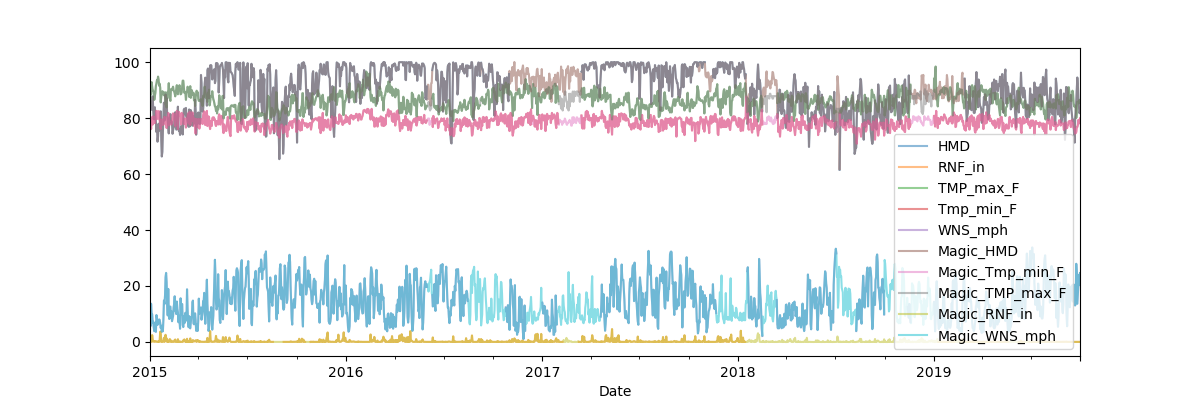

In [0]:
Magic_Tula_data.plot(figsize = (12,4), alpha =.5)

In [0]:
Magic_Tula_data

HMD    RNF_in  ...  Magic_RNF_in  Magic_WNS_mph
Date                             ...                             
2015-01-01  86.416667  0.944882  ...      0.944882      12.275208
2015-01-02  85.166667  0.118110  ...      0.118110       5.638953
2015-01-03  84.000000  0.157480  ...      0.157480      13.645334
2015-01-04  83.000000  0.039370  ...      0.039370       9.954383
2015-01-05  84.666667  2.401576  ...      2.401576       9.861177
...               ...       ...  ...           ...            ...
2019-09-26  92.125000  0.000000  ...      0.000000      17.159194
2019-09-27  86.375000  0.000000  ...      0.000000      20.906068
2019-09-28  84.166667  0.000000  ...      0.000000      23.991182
2019-09-29  81.750000  0.000000  ...      0.000000      20.290910
2019-09-30  82.450000  0.000000  ...      0.000000      24.617525

[1734 rows x 10 columns]

In [0]:
ASCC_All_combined.columns

Index(['Wind Speed', 'Hum', 'Rain', 'Tmp_max', 'Tmp_min'], dtype='object')

working on filling Hum
Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_424 (Dense)            (None, 12)                24        
_________________________________________________________________
dense_425 (Dense)            (None, 80)                1040      
_________________________________________________________________
dense_426 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_427 (Dense)            (None, 1)                 81        
Total params: 7,625
Trainable params: 7,625
Non-trainable params: 0
_________________________________________________________________
Score: loss of 1.0791583080750762; acc of 0.0%


<IPython.core.display.Javascript object>


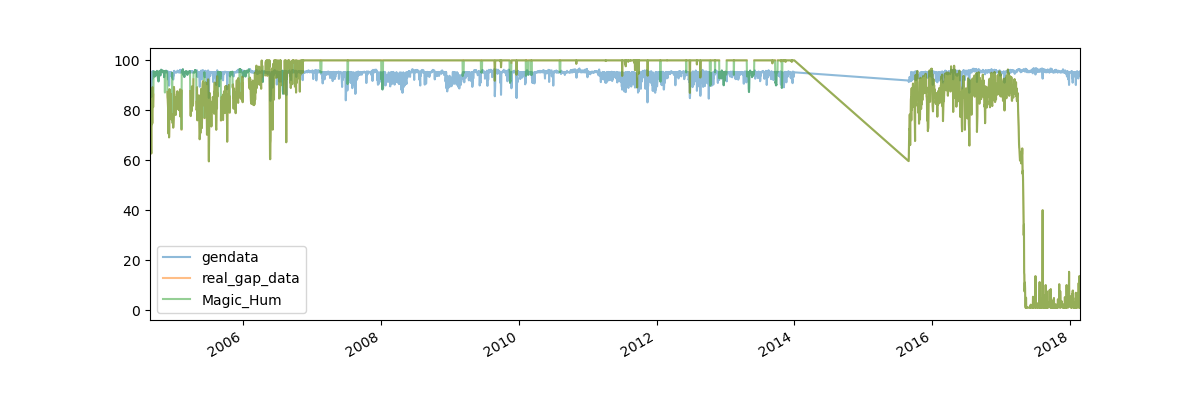

working on filling Tmp_min
Model: "sequential_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_428 (Dense)            (None, 12)                24        
_________________________________________________________________
dense_429 (Dense)            (None, 80)                1040      
_________________________________________________________________
dense_430 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_431 (Dense)            (None, 1)                 81        
Total params: 7,625
Trainable params: 7,625
Non-trainable params: 0
_________________________________________________________________
Score: loss of 0.5299471543775096; acc of 0.0%


<IPython.core.display.Javascript object>


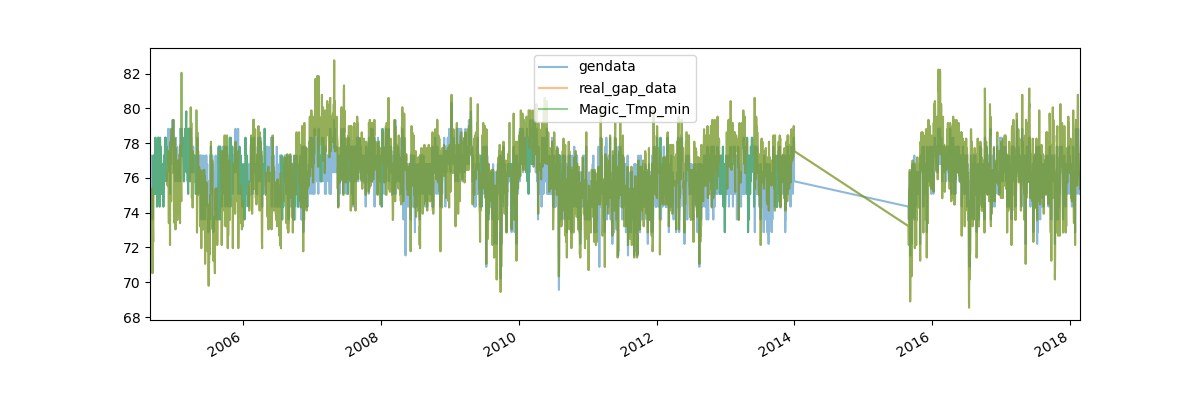

working on filling Tmp_max
Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_432 (Dense)            (None, 12)                24        
_________________________________________________________________
dense_433 (Dense)            (None, 80)                1040      
_________________________________________________________________
dense_434 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_435 (Dense)            (None, 1)                 81        
Total params: 7,625
Trainable params: 7,625
Non-trainable params: 0
_________________________________________________________________
Score: loss of 0.6801416992958057; acc of 0.0%


<IPython.core.display.Javascript object>


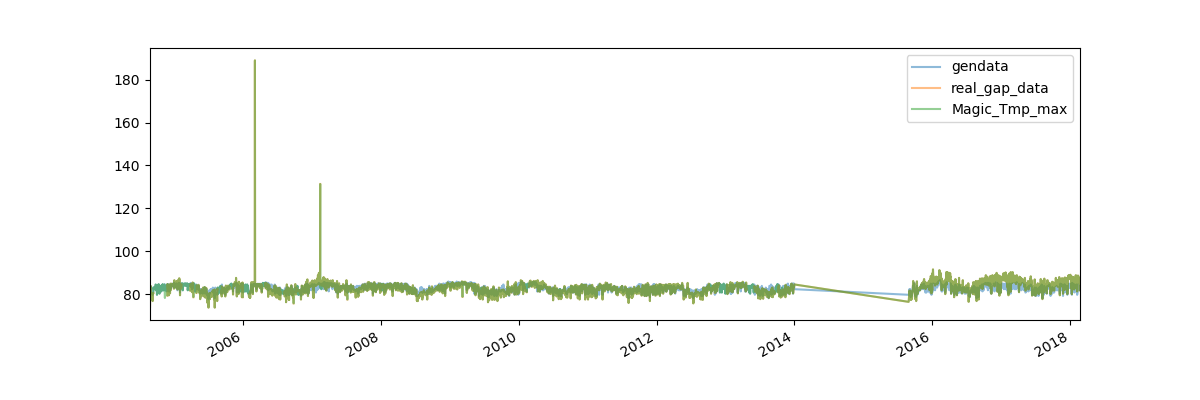

working on filling Rain
Model: "sequential_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_436 (Dense)            (None, 12)                24        
_________________________________________________________________
dense_437 (Dense)            (None, 80)                1040      
_________________________________________________________________
dense_438 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_439 (Dense)            (None, 1)                 81        
Total params: 7,625
Trainable params: 7,625
Non-trainable params: 0
_________________________________________________________________
Score: loss of 0.7059611765242196; acc of 0.0%


<IPython.core.display.Javascript object>


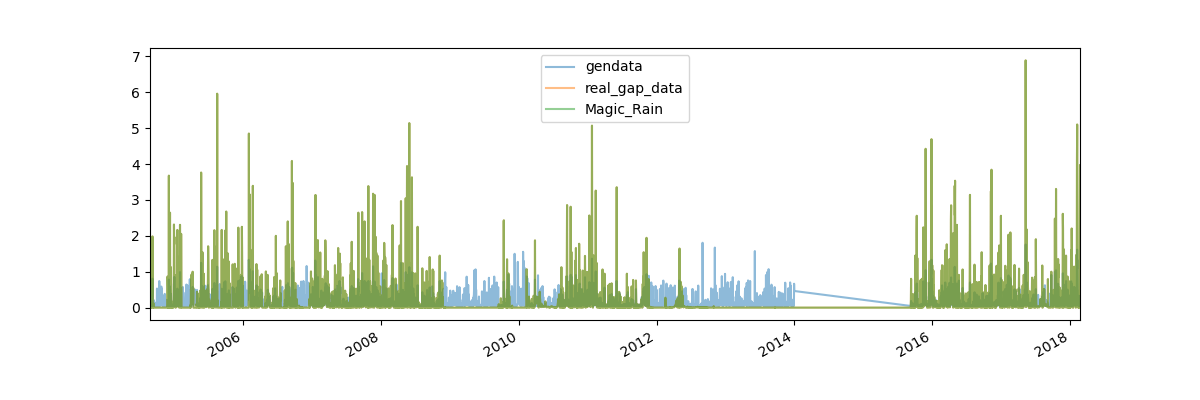

working on filling Wind Speed
Model: "sequential_104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_440 (Dense)            (None, 12)                24        
_________________________________________________________________
dense_441 (Dense)            (None, 80)                1040      
_________________________________________________________________
dense_442 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_443 (Dense)            (None, 1)                 81        
Total params: 7,625
Trainable params: 7,625
Non-trainable params: 0
_________________________________________________________________
Score: loss of 0.6056530447538486; acc of 0.0%


<IPython.core.display.Javascript object>


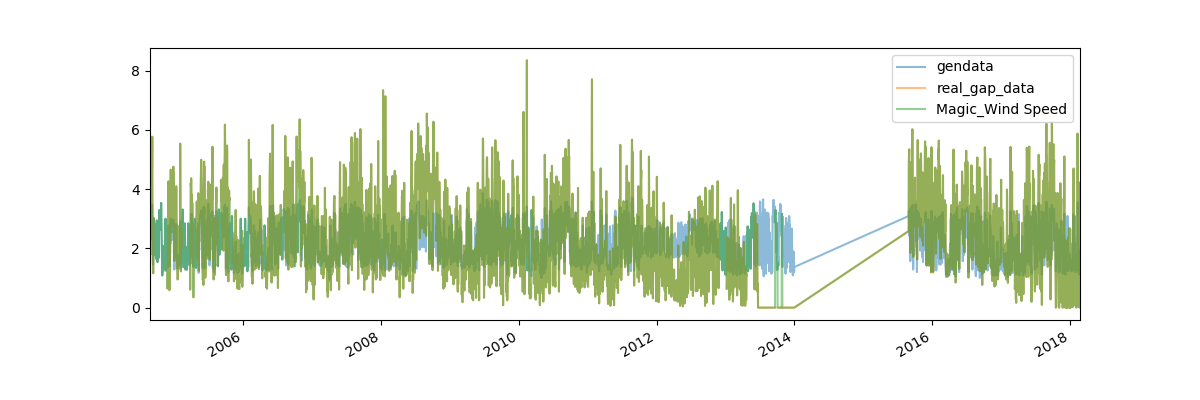

In [0]:
Magic_ASCC_data = ASCC_All_combined.copy()   # the end result container

ASCC_cols = ['Hum',           'Tmp_min', 'Tmp_max', 'Rain', 'Wind Speed']
PPG_cols  = ['RH_pct_filled', 'TMIN',    'TMAX',    'PRCP',   'AWND_filled']

# model checkpoint params  
checkpoint_path = os.path.join(workspace, 'testmodel_random_callback_save2.h5')
keras_callbacks   = [EarlyStopping(monitor='val_loss', patience=15, mode='min', min_delta=0.01),
                     ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')]

for idx, tcol in enumerate(ASCC_cols):
    print("working on filling {}".format(tcol))
    ppgcol = PPG_cols[idx]
    ASCC_temp_frame = ASCC_All_combined[[tcol]].copy()
    PPG_tempframe   = magic_data[[ppgcol]]

    # join the two colummns of same variable from different stations
    data = pd.merge(PPG_tempframe, ASCC_temp_frame, how='inner', left_index=True, right_index=True)   # careful with the behavior of inner, seems to leave gaps with nan values but starts the frame where both datasets exist  which is what I want
    train_data = data.dropna()       # remove any rows where there is no data (a gap) 

    # define and scale each dataset
    X_train = train_data[ppgcol].values 
    X_train = X_train.reshape(-1, 1)
    X_train_scaler = StandardScaler().fit(X_train)
    X_train = X_train_scaler.transform(X_train)

    y_train = train_data[tcol].values                 # scale the y data too, and then make the scale unique to use it to unscale the final data later
    y_train = y_train.reshape(-1, 1)
    y_train_scaler = StandardScaler().fit(y_train)
    y_train = y_train_scaler.transform(y_train)

    #set up the network a-fresh
    model = "reset"; del model   # redefine, then delete model to make sure previous model weights are DESTROIED!
    model = define_model_dense(hidden_layer_sizes, 1, activation, optimizer)    # input shape of 1 since only training on one columns

    # train the network
    history = model.fit(X_train, y_train, epochs=2000,verbose=0, validation_split = .5, callbacks=keras_callbacks)

    ## load the best saved model based on validation loss
    model = load_model(checkpoint_path)
    scores = model.evaluate(X_train, y_train, verbose=0)
    print(f'Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

    # now that we have the trained model, use it to predict parameter of interest. 
    X_fill = data[ppgcol].values 
    X_fill = X_fill.reshape(-1, 1)
    XScaler_dic[tcol] = StandardScaler().fit(X_fill)
    X_fill =  XScaler_dic[tcol].transform(X_fill)                       # scale existing data in other columns  
    y_pred_fill = model.predict(X_fill)                                 # use the network to generate predicted valued for desired column
    y_pred_fill = y_train_scaler.inverse_transform(y_pred_fill)         # rescale the data back to its real magnitudes

    generated_dataframe = pd.DataFrame(index = data.index, data = {"gendata":np.squeeze(y_pred_fill)})    
    generated_dataframe['real_gap_data'] = data[tcol]

    # if the real series has a gap fill with generated data, if not use real data
    generated_dataframe['Magic_{}'.format(tcol)] = generated_dataframe.apply(
        lambda row: row['gendata'] if np.isnan(row['real_gap_data']) else row['real_gap_data'], axis=1)   

    # merge it in to the big dataset
    Magic_ASCC_data['Magic_{}'.format(tcol)] = generated_dataframe['Magic_{}'.format(tcol)]
    
    generated_dataframe.plot(figsize = (12,4), alpha=.5)

# old stuff 

In [ ]:
# Use the model, fill the gaps 
even though the model is un-ideal at the moment....
On issue to fix someday is that the absolute magnitudes of the data don't get quite up to par (the slope is under predicted...)

# Set up the gap filling by definging datasets and IDing the series needeing filling.

magic_data = dataset_cleanish.copy()
all_cols = list(magic_data.columns)
train_data_all = unbroken_data

# this bit makes a list of the variable that need some filling. (1 or > gaps) 
broken_vars = []
for var in all_cols:
    wha = find_date_gaps(dataset_cleanish, var)
    
    if wha[0]:                   # this means if the gap start lists are not empty
        broken_vars.append(var)  # make the list of broken variables

In [ ]:
# hyperparameters
hidden_layer_sizes =  [12, 80, 80]
input_shape = len(x_cols)
activation     = 'relu'
optimizer      = 'sgd'

# loop over each of the variables and see how well gap filling works (on the validataion data)
variables_of_interest = ['AWND', 'PRCP', 'TMAX', 'TMIN', 'RH_pct']

for i in variables_of_interest:
    print("Workimg on {}".format(i))
    x_cols = ['AWND', 'PRCP', 'TMAX', 'TMIN', 'RH_pct']
    x_cols.remove(i)                                     # remove the param of interest
    y_col = i

    model, X_train_scaler, y_train_scaler = make_run_plot_validate_PPG_filling(unbroken_data, x_cols, y_col, hidden_layer_sizes, input_shape, activation, optimizer, TS_value = .75)

In [ ]:
### Compare to simply gap filling with the mean

# run the training dataset back through the netowrk to show how well it can match its traing values over calibration data (comp vs obs)    # this is a first order 

#### All plots
fig2, ax = plt.subplots(1, 1, figsize=(3, 3))

###### plot 1 to 1 for # view results of predictions on the validation data 
y_pred_validation = np.full(np.shape(y_val), y_val.mean())
y_pred_validation = y_val_scaler.inverse_transform(y_pred_validation)    # unscale the final data baed on the scaler from the initial scaling cell abovee

xval = np.squeeze(val_data[y_col].values)
yval = np.squeeze(y_pred_validation)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xval, yval)                              # get stats on regression
mea = np.mean(np.abs(xval-yval))
rmse = np.sqrt(np.mean(np.abs(xval-yval)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error
Std_RMSE = rmse/((np.mean(xval)+np.mean(yval))/2)                                 # standardize the RMSE as a % of the mean
ax.plot(np.unique(xval), np.poly1d(np.polyfit(xval, yval, 1))(np.unique(xval)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
ax.scatter(xval, yval, label="r2={0:1.2f}, slope={1:1.2f}\nRMSE={2:1.2f} S_RMSE={3:1.2f}".format(r_value, slope, rmse, Std_RMSE))   
ax.set_title('Actual vs simulated data Validation')
ax.legend()

##### time series plot
plt.figure(figsize=(12, 4))
plt.plot(train_data.index, ycal, label='Predicted')
train_data[y_col].plot(label='Actual', alpha = .5)
plt.plot(val_data.index, yval, label='Predicted')
val_data[y_col].plot(label='Actual', alpha = .5)
plt.legend(loc='best')

In [ ]:
Turned into function above  here for record 

TRAIN_SPLIT = int(len(unbroken_data)*.80)     # train on say 2/3 of the data validate on the rest
# split data for train and validation
train_data = unbroken_data.iloc[:TRAIN_SPLIT]
val_data = unbroken_data.iloc[TRAIN_SPLIT:]


# determine which column to work with
x_cols = ['AWND', 'PRCP', 'TMIN', 'TMAX']
y_col = 'RH_pct'


# set up the training datasets
X_train = train_data[x_cols].values  
# scale the x component of the training data
X_train_scaler = StandardScaler().fit(X_train)
X_train = X_train_scaler.transform(X_train)

y_train = train_data[y_col].values                 # scale the y data too, and then make the scale unique to use it to unscale the final data later
y_train = y_train.reshape(-1, 1)
y_train_scaler = StandardScaler().fit(y_train)
y_train = y_train_scaler.transform(y_train)


# set up the validation datasets
X_val = val_data[x_cols].values  
# scale the x component of the training data
X_val_scaler = StandardScaler().fit(X_val)
X_val = X_val_scaler.transform(X_val)

y_val = val_data[y_col].values
y_val = y_val.reshape(-1, 1)
y_val_scaler = StandardScaler().fit(y_val)
y_val = y_val_scaler.transform(y_val)






















# run the training dataset back through the netowrk to show how well it can match its traing values over calibration data (comp vs obs)    # this is a first order 

#### All plots
fig2, ax = plt.subplots(1, 3, figsize=(9, 3))

######## plot 1 to 1 for # view results of predictions on the calibration data 
y_pred_calibration = model.predict(X_train)
y_pred_calibration = y_train_scaler.inverse_transform(y_pred_calibration)    # unscale the final data baed on the scaler from the initial scaling cell abovee

xcal = np.squeeze(train_data[y_col].values)
ycal = np.squeeze(y_pred_calibration)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xcal, ycal)                              # get stats on regression
mea = np.mean(np.abs(xcal-ycal))
rmse = np.sqrt(np.mean(np.abs(xcal-ycal)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error
Std_RMSE = rmse/((np.mean(xcal)+np.mean(ycal))/2)                                 # standardize the RMSE as a % of the mean
ax[0].plot(np.unique(xcal), np.poly1d(np.polyfit(xcal, ycal, 1))(np.unique(xcal)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
ax[0].scatter(xcal, ycal, label="r2={0:1.2f}, slope={1:1.2f}\nRMSE={2:1.2f} S_RMSE={3:1.2f}".format(r_value, slope, rmse, Std_RMSE))   
ax[0].set_title('Actual vs simulated data Calibration')
ax[0].legend()

###### Plot losses
ax[1].set_title('Loss vs. Epoch')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])

###### plot 1 to 1 for # view results of predictions on the validation data 
y_pred_validation = model.predict(X_val)
y_pred_validation = y_val_scaler.inverse_transform(y_pred_validation)    # unscale the final data baed on the scaler from the initial scaling cell abovee

xval = np.squeeze(val_data[y_col].values)
yval = np.squeeze(y_pred_validation)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xval, yval)                              # get stats on regression
mea = np.mean(np.abs(xval-yval))
rmse = np.sqrt(np.mean(np.abs(xval-yval)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error
Std_RMSE = rmse/((np.mean(xval)+np.mean(yval))/2)                                 # standardize the RMSE as a % of the mean
ax[2].plot(np.unique(xval), np.poly1d(np.polyfit(xval, yval, 1))(np.unique(xval)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
ax[2].scatter(xval, yval, label="r2={0:1.2f}, slope={1:1.2f}\nRMSE={2:1.2f} S_RMSE={3:1.2f}".format(r_value, slope, rmse, Std_RMSE))   
ax[2].set_title('Actual vs simulated data Validation')
ax[2].legend()

##### time series plot
plt.figure(figsize=(12, 4))
plt.plot(train_data.index, ycal, label='Predicted')
train_data[y_col].plot(label='Actual', alpha = .5)
plt.plot(val_data.index, yval, label='Predicted')
val_data[y_col].plot(label='Actual', alpha = .5)
plt.legend(loc='best')









# define the training data sets as unbrokem portion of the dataframe

x_cols = ['AWND', 'PRCP', 'TMIN', 'TMAX']
y_col = 'RH_pct'

X_train, y_train, X_val, y_val, train_data, val_data, y_train_scaler, y_val_scaler = make_training_dataset(unbroken_data, x_cols, y_col, TS_value = 0.80)

#define the DL model and its parameters to use for other models creates object named model in memory

hidden_layer_sizes =  [12, 80, 80]
input_shape = len(x_cols)
activation     = 'relu'
optimizer      = 'sgd'

model = "reset"; del model                                                           # redefine, then delete model to make sure previous model weights are DESTROIED!
model = define_model_dense(hidden_layer_sizes, input_shape, activation, optimizer)

# train the network
# Note using callbacks from ( https://www.machinecurve.com/index.php/2019/05/30/avoid-wasting-resources-with-earlystopping-and-modelcheckpoint-in-keras/ )
checkpoint_path = os.path.join(workspace, 'testmodel_random_callback_save2.h5')

keras_callbacks   = [EarlyStopping(monitor='val_loss', patience=150, mode='min', min_delta=0.001),
                     ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')]

history = model.fit(X_train, y_train, epochs=2000,verbose=1, validation_data =(X_val,  y_val), callbacks=keras_callbacks)

## load the best saved model based on validation loss
model = load_model(checkpoint_path)
scores = model.evaluate(X_train, y_train, verbose=1)
print(f'Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')



#### Plot results
fig2, ax = plt.subplots(1, 3, figsize=(9, 3))

######## plot 1 to 1 for # view results of predictions on the calibration data 
y_pred_calibration = model.predict(X_train)
y_pred_calibration = y_train_scaler.inverse_transform(y_pred_calibration)    # unscale the final data baed on the scaler from the initial scaling cell abovee

xcal = np.squeeze(train_data[y_col].values)
ycal = np.squeeze(y_pred_calibration)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xcal, ycal)                              # get stats on regression
mea = np.mean(np.abs(xcal-ycal))
rmse = np.sqrt(np.mean(np.abs(xcal-ycal)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error
Std_RMSE = rmse/((np.mean(xcal)+np.mean(ycal))/2)                                 # standardize the RMSE as a % of the mean
ax[0].plot(np.unique(xcal), np.poly1d(np.polyfit(xcal, ycal, 1))(np.unique(xcal)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
ax[0].scatter(xcal, ycal, label="r2={0:1.2f}, slope={1:1.2f}\nRMSE={2:1.2f} S_RMSE={3:1.2f}".format(r_value, slope, rmse, Std_RMSE))   
ax[0].set_title('Actual vs simulated data Calibration')
ax[0].legend()

###### Plot losses
ax[1].set_title('Loss vs. Epoch')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])

###### plot 1 to 1 for # view results of predictions on the validation data 
y_pred_validation = model.predict(X_val)
y_pred_validation = y_val_scaler.inverse_transform(y_pred_validation)    # unscale the final data baed on the scaler from the initial scaling cell abovee

xval = np.squeeze(val_data[y_col].values)
yval = np.squeeze(y_pred_validation)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xval, yval)                              # get stats on regression
mea = np.mean(np.abs(xval-yval))
rmse = np.sqrt(np.mean(np.abs(xval-yval)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error
Std_RMSE = rmse/((np.mean(xval)+np.mean(yval))/2)                                 # standardize the RMSE as a % of the mean
ax[2].plot(np.unique(xval), np.poly1d(np.polyfit(xval, yval, 1))(np.unique(xval)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
ax[2].scatter(xval, yval, label="r2={0:1.2f}, slope={1:1.2f}\nRMSE={2:1.2f} S_RMSE={3:1.2f}".format(r_value, slope, rmse, Std_RMSE))   
ax[2].set_title('Actual vs simulated data Validation')
ax[2].legend()

##### time series plot
plt.figure(figsize=(8, 3))
plt.plot(train_data.index, ycal, label='Predicted')
train_data[y_col].plot(label='Actual', alpha = .5)
plt.plot(val_data.index, yval, label='Predicted')
val_data[y_col].plot(label='Actual', alpha = .5)
plt.legend(loc='best')


In [0]:
Probably useless, looking at CNNs   https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf